# Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import skew, kurtosis
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Convert to Datetime

In [2]:
df = pd.read_csv("Data/stock0_day0_trades.csv.gz", index_col="ts")
df

price  qty
ts                                    
2026-01-26 09:00:27.018202  55.00    2
2026-01-26 09:00:27.018202  55.00   10
2026-01-26 09:00:27.018202  55.00   10
2026-01-26 09:00:27.041728  54.97  446
2026-01-26 09:00:27.042153  54.97   24
...                           ...  ...
2026-01-26 17:29:58.691949  55.64   67
2026-01-26 17:29:58.691949  55.64  186
2026-01-26 17:29:58.691949  55.64    3
2026-01-26 17:29:58.691949  55.64   11
2026-01-26 17:29:58.691949  55.64  200

[19076 rows x 2 columns]

In [3]:
df.index = pd.to_datetime(df.index)

In [4]:
df

price  qty
ts                                    
2026-01-26 09:00:27.018202  55.00    2
2026-01-26 09:00:27.018202  55.00   10
2026-01-26 09:00:27.018202  55.00   10
2026-01-26 09:00:27.041728  54.97  446
2026-01-26 09:00:27.042153  54.97   24
...                           ...  ...
2026-01-26 17:29:58.691949  55.64   67
2026-01-26 17:29:58.691949  55.64  186
2026-01-26 17:29:58.691949  55.64    3
2026-01-26 17:29:58.691949  55.64   11
2026-01-26 17:29:58.691949  55.64  200

[19076 rows x 2 columns]

In [5]:
type(df.index.values[0])

numpy.datetime64

In [6]:
def open_convert_data(name : str) -> pd.DataFrame :
    df = pd.read_csv(f"Data/{name}", index_col="ts")
    df.index = pd.to_datetime(df.index)
    return df

In [7]:
test = open_convert_data("stock0_day0_updates.csv.gz")

In [8]:
test

type     bp       bq     ap       aq
ts                                                             
2026-01-26 09:00:00.340497    U    NaN  19671.0    NaN  24789.0
2026-01-26 09:00:00.503532    U    NaN  19671.0    NaN  24789.0
2026-01-26 09:00:00.503539    U    NaN  19671.0    NaN  24789.0
2026-01-26 09:00:00.503565    U    NaN  19671.0    NaN  24789.0
2026-01-26 09:00:00.503735    U    NaN  19671.0    NaN  24789.0
...                         ...    ...      ...    ...      ...
2026-01-26 17:29:58.696978    U  55.63    337.0  55.65    462.0
2026-01-26 17:29:58.697298    U  55.63    557.0  55.65    462.0
2026-01-26 17:29:59.044651    U  55.63    517.0  55.65    462.0
2026-01-26 17:29:59.123752    U  55.63    522.0  55.65    462.0
2026-01-26 17:29:59.615517    U  55.63    523.0  55.65    462.0

[226217 rows x 5 columns]

# Question 1 : Trades

## 1.1 Data exploration

## Dataset

In [9]:
df0_j0 = open_convert_data("stock0_day0_trades.csv.gz")
df0_j1 = open_convert_data("stock0_day1_trades.csv.gz")
df0_j2 = open_convert_data("stock0_day2_trades.csv.gz")

df1_j0 = open_convert_data("stock1_day0_trades.csv.gz")
df1_j1 = open_convert_data("stock1_day1_trades.csv.gz")
df1_j2 = open_convert_data("stock1_day2_trades.csv.gz")

df2_j0 = open_convert_data("stock2_day0_trades.csv.gz")
df2_j1 = open_convert_data("stock2_day1_trades.csv.gz")
df2_j2 = open_convert_data("stock2_day2_trades.csv.gz")

In [10]:
all_dfs = {
    'Stock0_day0': df0_j0,
    'Stock0_day1': df0_j1,
    'Stock0_day2': df0_j2,
    'Stock1_day0': df1_j0,
    'Stock1_day1': df1_j1,
    'Stock1_day2': df1_j2,
    'Stock2_day0': df2_j0,
    'Stock2_day1': df2_j1,
    'Stock2_day2': df2_j2,
}

In [11]:
for name, df in all_dfs.items():
    print(f"\n{'='*70}")
    print(f"ANALYSE: {name}")
    print(f"{'='*70}")
    
    # Types et structure
    print(f"\nShape: {df.shape[0]:,} rows × {df.shape[1]} columns")
    print(f"\nData types:")
    print(df.dtypes)
    
    # Valeurs manquantes
    print(f"\nValeurs manquantes:")
    missing = df.isna().sum()
    if missing.sum() == 0:
        print("  ✓ Aucune valeur manquante")
    else:
        print(missing[missing > 0])
    
    # Statistiques descriptives
    print(f"\nStatistiques descriptives:")
    print(df.describe())
    
    # Checks qualité
    print(f"\nVérifications qualité:")
    
    # Prix négatifs
    if 'price' in df.columns:
        neg_prices = (df['price'] < 0).sum()
        if neg_prices > 0:
            print(f"  ⚠ {neg_prices} prix négatifs")
        else:
            print(f"  ✓ Pas de prix négatifs")
    
    # Quantités négatives/nulles
    if 'qty' in df.columns:
        zero_qty = (df['qty'] <= 0).sum()
        if zero_qty > 0:
            print(f"  ⚠ {zero_qty} quantités nulles/négatives")
        else:
            print(f"  ✓ Toutes les quantités positives")
    
    # Doublons
    dup_count = df.duplicated().sum()
    if dup_count > 0:
        print(f"  ⚠ {dup_count} lignes dupliquées")
    else:
        print(f"  ✓ Pas de doublons")
    
    # Ordre temporel
    if df.index.is_monotonic_increasing:
        print(f"  ✓ Timestamps ordonnés")
    else:
        print(f"  ⚠ Timestamps non ordonnés")
    
    # Patterns de trading
    if isinstance(df.index, pd.DatetimeIndex):
        print(f"\nPatterns de trading:")
        time_diffs = df.index.to_series().diff()
        print(f"  Temps entre trades (médian): {time_diffs.median()}")
        print(f"  Temps entre trades (moyen): {time_diffs.mean()}")


ANALYSE: Stock0_day0

Shape: 19,076 rows × 2 columns

Data types:
price    float64
qty        int64
dtype: object

Valeurs manquantes:
  ✓ Aucune valeur manquante

Statistiques descriptives:
              price           qty
count  19076.000000  19076.000000
mean      55.430137    134.961260
std        0.165443    231.604595
min       54.840000      1.000000
25%       55.340000     40.000000
50%       55.420000    114.000000
75%       55.550000    152.000000
max       55.740000  11400.000000

Vérifications qualité:
  ✓ Pas de prix négatifs
  ✓ Toutes les quantités positives
  ⚠ 10917 lignes dupliquées
  ✓ Timestamps ordonnés

Patterns de trading:
  Temps entre trades (médian): 0 days 00:00:00.000008
  Temps entre trades (moyen): 0 days 00:00:01.602708977

ANALYSE: Stock0_day1

Shape: 21,933 rows × 2 columns

Data types:
price    float64
qty        int64
dtype: object

Valeurs manquantes:
  ✓ Aucune valeur manquante

Statistiques descriptives:
              price           qty
count  2

In [12]:
print(f"\n{'='*70}")
print(f"ANALYSE DÉTAILLÉE DES DOUBLONS")
print(f"{'='*70}\n")

for name, df in all_dfs.items():
    dup_count = df.duplicated().sum()
    
    if dup_count > 0:
        print(f"\n{name}:")
        print(f"  Total doublons: {dup_count} ({100*dup_count/len(df):.2f}%)")
        
        # Doublons complets (toutes les colonnes identiques)
        duplicated_rows = df[df.duplicated(keep=False)]
        print(f"  Lignes concernées: {len(duplicated_rows)}")
        
        # Montrer quelques exemples
        print(f"\n  Exemples de doublons:")
        print(duplicated_rows.head(10))
        
        # Vérifier si ce sont des doublons sur le timestamp aussi
        dup_on_index = df.index.duplicated().sum()
        print(f"\n  Doublons sur timestamp: {dup_on_index}")
        
        # Analyser les doublons : sont-ils consécutifs ou dispersés ?
        dup_mask = df.duplicated(keep='first')
        dup_indices = df.index[dup_mask]
        if len(dup_indices) > 0:
            print(f"  Premier doublon à: {dup_indices[0]}")
            print(f"  Dernier doublon à: {dup_indices[-1]}")


ANALYSE DÉTAILLÉE DES DOUBLONS


Stock0_day0:
  Total doublons: 10917 (57.23%)
  Lignes concernées: 13878

  Exemples de doublons:
                            price  qty
ts                                    
2026-01-26 09:00:27.018202  55.00    2
2026-01-26 09:00:27.018202  55.00   10
2026-01-26 09:00:27.018202  55.00   10
2026-01-26 09:00:27.061584  54.97  125
2026-01-26 09:00:27.072145  54.95  125
2026-01-26 09:00:27.336175  54.95  125
2026-01-26 09:00:27.336496  54.95  125
2026-01-26 09:00:27.348460  54.95  125
2026-01-26 09:00:28.966403  54.94    3
2026-01-26 09:00:28.966403  54.94    1

  Doublons sur timestamp: 9507
  Premier doublon à: 2026-01-26 09:00:27.018202
  Dernier doublon à: 2026-01-26 17:29:58.691949

Stock0_day1:
  Total doublons: 13301 (60.64%)
  Lignes concernées: 17102

  Exemples de doublons:
                            price  qty
ts                                    
2026-01-27 09:00:16.759545  55.56  100
2026-01-27 09:00:16.759545  55.56    2
2026-01-27 09:00:

1. Évolution des prix pour tous les datasets...


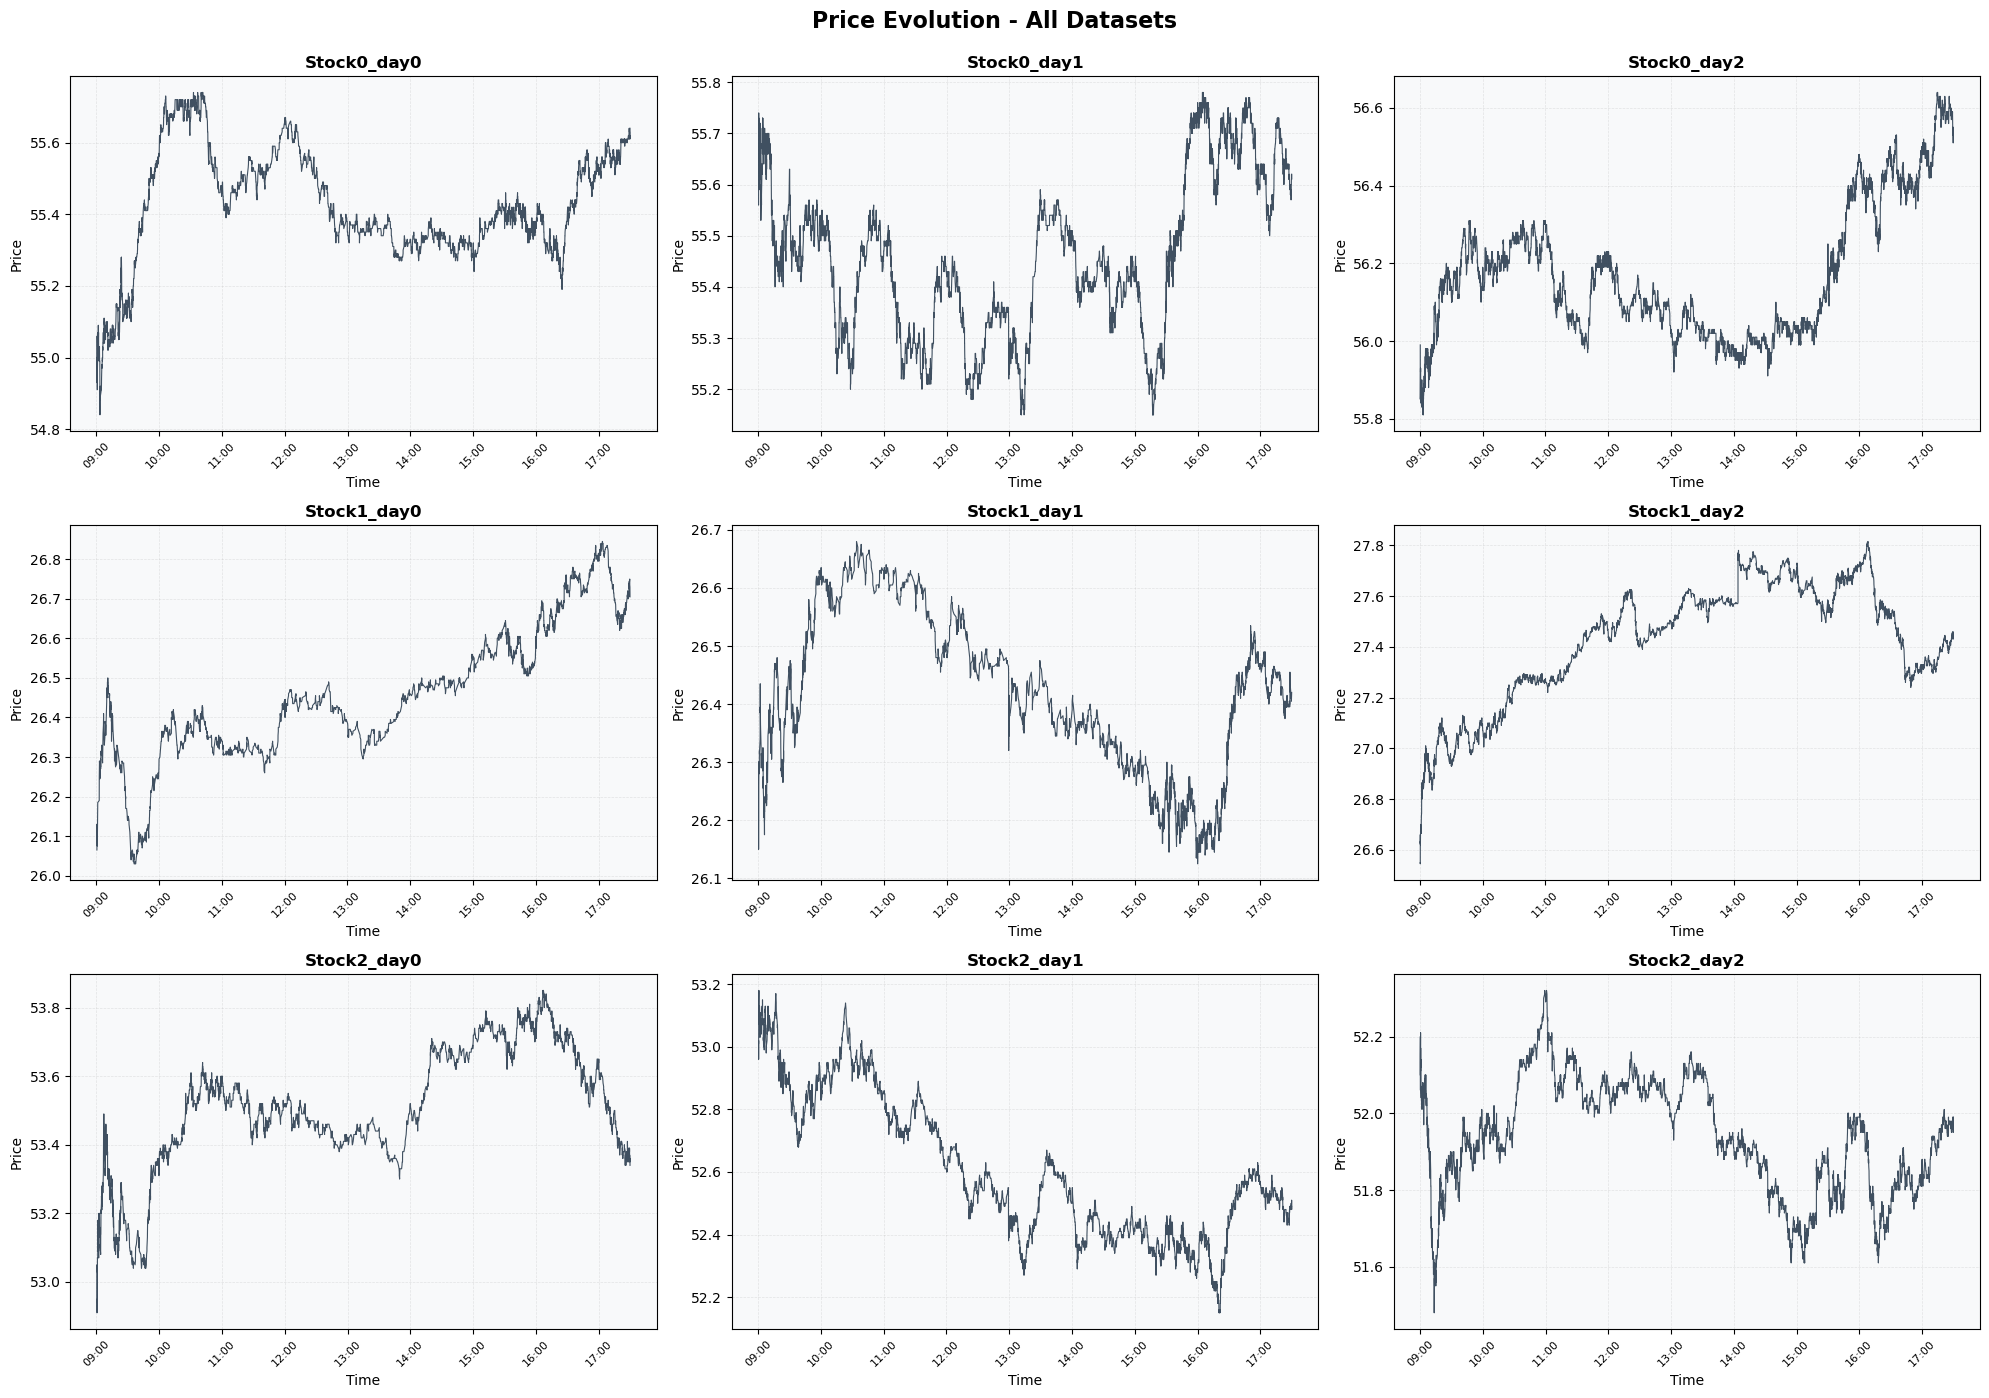

In [13]:
print("1. Évolution des prix pour tous les datasets...")

fig, axes = plt.subplots(3, 3, figsize=(20, 14))
axes = axes.flatten()

for idx, (name, df) in enumerate(all_dfs.items()):
    if 'price' in df.columns:
        axes[idx].plot(df.index, df['price'], linewidth=0.8, color='#2C3E50', alpha=0.9)
        axes[idx].set_title(f'{name}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Time', fontsize=10)
        axes[idx].set_ylabel('Price', fontsize=10)
        axes[idx].grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
        axes[idx].set_facecolor('#F8F9FA')
        axes[idx].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        axes[idx].tick_params(axis='x', rotation=45, labelsize=8)

plt.suptitle('Price Evolution - All Datasets', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

2. Distributions des prix pour tous les datasets...


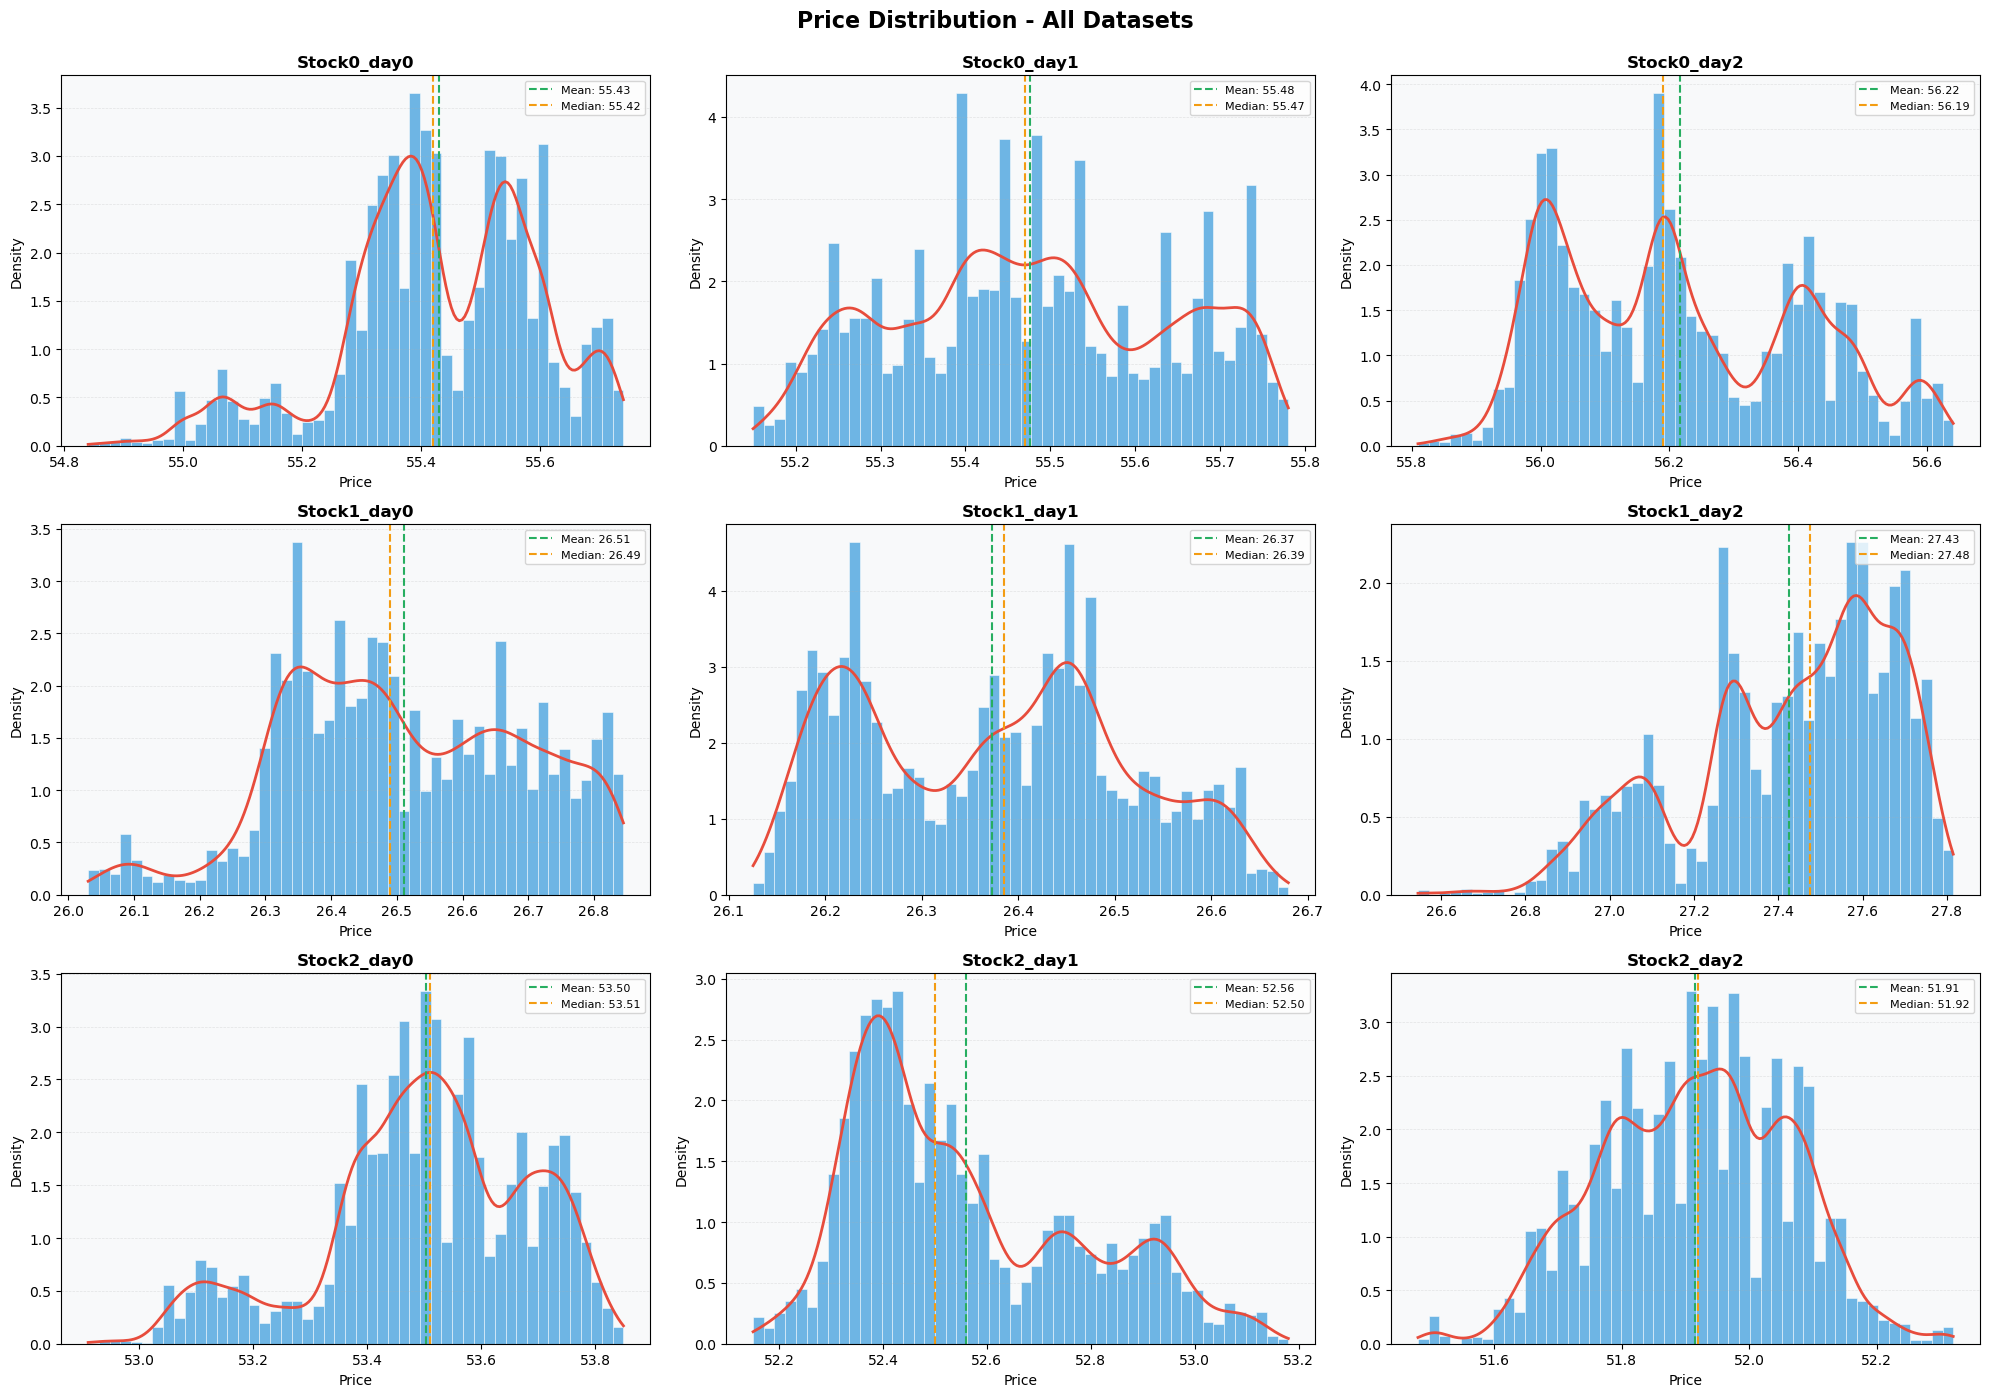

In [14]:
print("2. Distributions des prix pour tous les datasets...")

fig, axes = plt.subplots(3, 3, figsize=(20, 14))
axes = axes.flatten()

for idx, (name, df) in enumerate(all_dfs.items()):
    if 'price' in df.columns:
        # Histogramme
        axes[idx].hist(df['price'], bins=50, density=True, alpha=0.7,
                      color='#3498DB', edgecolor='white', linewidth=0.5)
        
        # Kernel density
        density = stats.gaussian_kde(df['price'])
        xs = np.linspace(df['price'].min(), df['price'].max(), 200)
        axes[idx].plot(xs, density(xs), color='#E74C3C', linewidth=2)
        
        # Statistiques
        mean_price = df['price'].mean()
        median_price = df['price'].median()
        axes[idx].axvline(mean_price, color='#27AE60', linestyle='--', linewidth=1.5,
                         label=f'Mean: {mean_price:.2f}')
        axes[idx].axvline(median_price, color='#F39C12', linestyle='--', linewidth=1.5,
                         label=f'Median: {median_price:.2f}')
        
        axes[idx].set_title(f'{name}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Price', fontsize=10)
        axes[idx].set_ylabel('Density', fontsize=10)
        axes[idx].grid(True, alpha=0.3, linestyle='--', linewidth=0.5, axis='y')
        axes[idx].set_facecolor('#F8F9FA')
        axes[idx].legend(fontsize=8, loc='upper right')

plt.suptitle('Price Distribution - All Datasets', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

3. Distributions des quantités pour tous les datasets...


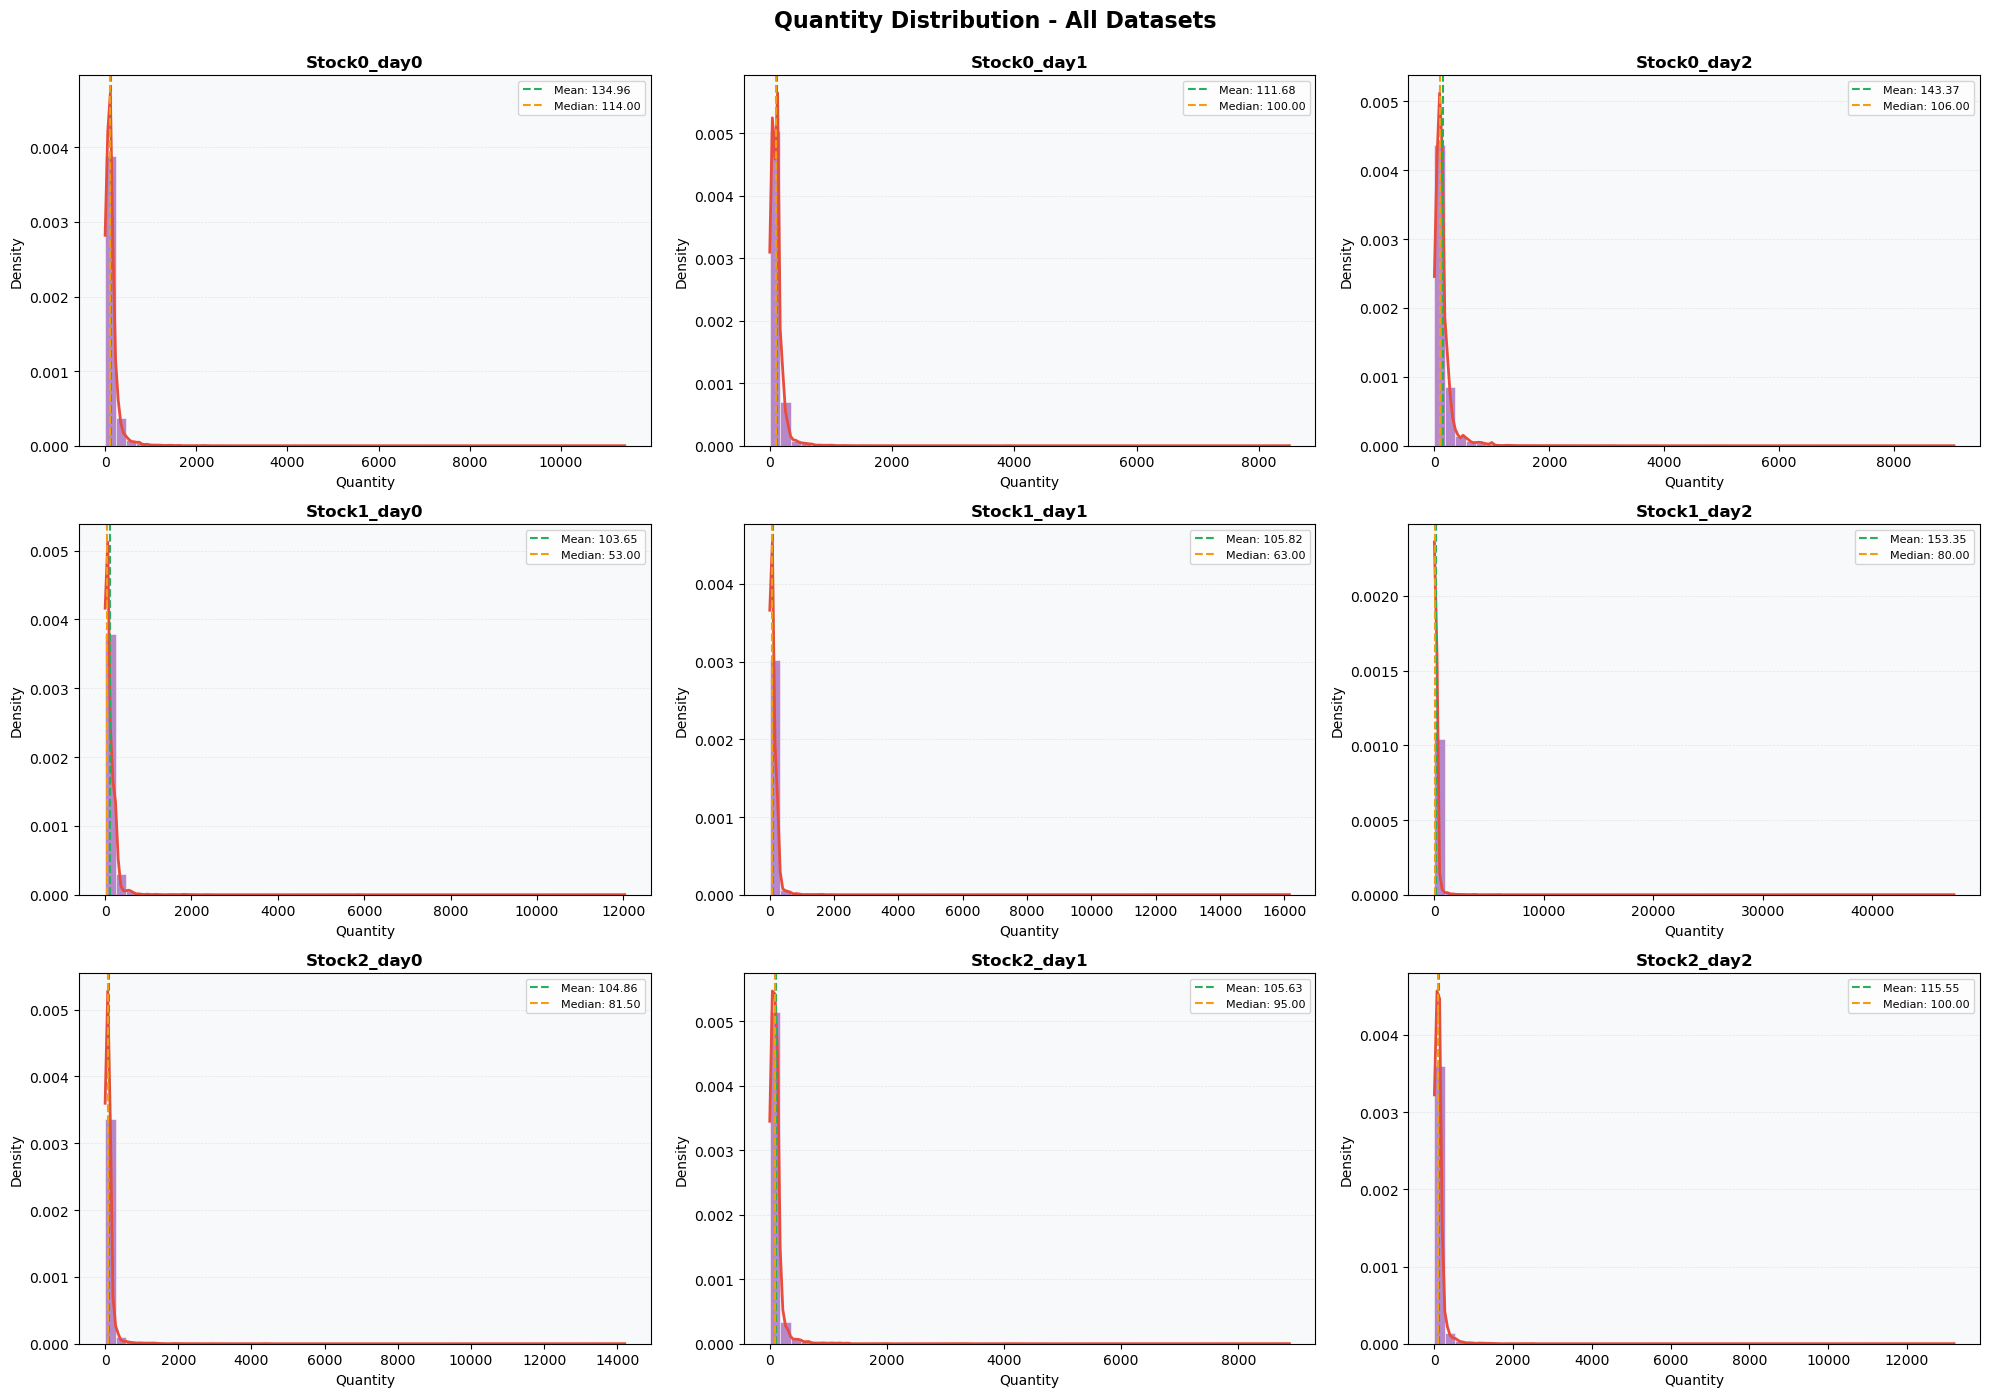

In [15]:
print("3. Distributions des quantités pour tous les datasets...")

fig, axes = plt.subplots(3, 3, figsize=(20, 14))
axes = axes.flatten()

for idx, (name, df) in enumerate(all_dfs.items()):
    if 'qty' in df.columns:
        # Histogramme
        axes[idx].hist(df['qty'], bins=50, density=True, alpha=0.7,
                      color='#9B59B6', edgecolor='white', linewidth=0.5)
        
        # Kernel density
        density = stats.gaussian_kde(df['qty'])
        xs = np.linspace(df['qty'].min(), df['qty'].max(), 200)
        axes[idx].plot(xs, density(xs), color='#E74C3C', linewidth=2)
        
        # Statistiques
        mean_qty = df['qty'].mean()
        median_qty = df['qty'].median()
        axes[idx].axvline(mean_qty, color='#27AE60', linestyle='--', linewidth=1.5,
                         label=f'Mean: {mean_qty:.2f}')
        axes[idx].axvline(median_qty, color='#F39C12', linestyle='--', linewidth=1.5,
                         label=f'Median: {median_qty:.2f}')
        
        axes[idx].set_title(f'{name}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Quantity', fontsize=10)
        axes[idx].set_ylabel('Density', fontsize=10)
        axes[idx].grid(True, alpha=0.3, linestyle='--', linewidth=0.5, axis='y')
        axes[idx].set_facecolor('#F8F9FA')
        axes[idx].legend(fontsize=8, loc='upper right')

plt.suptitle('Quantity Distribution - All Datasets', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [16]:
print("\n4. Statistiques récapitulatives des prix:")

price_stats = []
for name, df in all_dfs.items():
    if 'price' in df.columns:
        stats = {
            'Dataset': name,
            'Mean': f"{df['price'].mean():.4f}",
            'Median': f"{df['price'].median():.4f}",
            'Std': f"{df['price'].std():.4f}",
            'Min': f"{df['price'].min():.4f}",
            'Max': f"{df['price'].max():.4f}",
            'Skewness': f"{df['price'].skew():.4f}",
            'Kurtosis': f"{df['price'].kurtosis():.4f}"
        }
        price_stats.append(stats)

price_stats_df = pd.DataFrame(price_stats)
print(price_stats_df.to_string(index=False))


4. Statistiques récapitulatives des prix:
    Dataset    Mean  Median    Std     Min     Max Skewness Kurtosis
Stock0_day0 55.4301 55.4200 0.1654 54.8400 55.7400  -0.5435   0.2436
Stock0_day1 55.4764 55.4700 0.1610 55.1500 55.7800   0.0428  -1.0016
Stock0_day2 56.2169 56.1900 0.1900 55.8100 56.6400   0.3586  -0.9620
Stock1_day0 26.5116 26.4900 0.1831 26.0300 26.8450  -0.0829  -0.6311
Stock1_day1 26.3732 26.3850 0.1384 26.1250 26.6800   0.1223  -1.0911
Stock1_day2 27.4264 27.4750 0.2442 26.5450 27.8150  -0.6761  -0.3557
Stock2_day0 53.5026 53.5100 0.1819 52.9100 53.8500  -0.5526  -0.0090
Stock2_day1 52.5595 52.5000 0.2240 52.1500 53.1800   0.7032  -0.5151
Stock2_day2 51.9144 51.9200 0.1468 51.4800 52.3200  -0.0949  -0.4377


In [17]:
print("\n5. Statistiques récapitulatives des quantités:")

qty_stats = []
for name, df in all_dfs.items():
    if 'qty' in df.columns:
        stats = {
            'Dataset': name,
            'Mean': f"{df['qty'].mean():.4f}",
            'Median': f"{df['qty'].median():.4f}",
            'Std': f"{df['qty'].std():.4f}",
            'Min': f"{df['qty'].min():.4f}",
            'Max': f"{df['qty'].max():.4f}",
            'Skewness': f"{df['qty'].skew():.4f}",
            'Kurtosis': f"{df['qty'].kurtosis():.4f}"
        }
        qty_stats.append(stats)

qty_stats_df = pd.DataFrame(qty_stats)
print(qty_stats_df.to_string(index=False))


5. Statistiques récapitulatives des quantités:
    Dataset     Mean   Median      Std    Min        Max Skewness  Kurtosis
Stock0_day0 134.9613 114.0000 231.6046 1.0000 11400.0000  20.9443  744.4865
Stock0_day1 111.6813 100.0000 174.1195 1.0000  8500.0000  23.4408  881.4031
Stock0_day2 143.3657 106.0000 220.0030 1.0000  9042.0000  14.0604  372.1328
Stock1_day0 103.6491  53.0000 233.5950 1.0000 12031.0000  31.3620 1462.7883
Stock1_day1 105.8199  63.0000 270.4308 1.0000 16153.0000  39.6534 2171.0920
Stock1_day2 153.3522  80.0000 606.9358 1.0000 47478.0000  52.7307 3790.6241
Stock2_day0 104.8615  81.5000 269.6994 1.0000 14203.0000  27.1148 1106.4344
Stock2_day1 105.6340  95.0000 195.3067 1.0000  8871.0000  19.3753  626.0143
Stock2_day2 115.5536 100.0000 237.1586 1.0000 13197.0000  29.9256 1330.1018


In [18]:
print(f"\n{'='*70}")
print(f"RÉSUMÉ COMPARATIF - TOUS LES DATASETS")
print(f"{'='*70}\n")

summary = []
for name, df in all_dfs.items():
    stats_dict = {
        'Dataset': name,
        'Trades': f"{len(df):,}",
        'Missing': df.isna().sum().sum(),
        'Duplicates': df.duplicated().sum()
    }
    
    if 'price' in df.columns:
        stats_dict['Mean_Price'] = f"{df['price'].mean():.4f}"
        stats_dict['Std_Price'] = f"{df['price'].std():.4f}"
    
    if 'qty' in df.columns:
        stats_dict['Mean_Qty'] = f"{df['qty'].mean():.2f}"
        stats_dict['Total_Qty'] = f"{df['qty'].sum():.0f}"
    
    summary.append(stats_dict)

summary_df = pd.DataFrame(summary)
print(summary_df.to_string(index=False))


RÉSUMÉ COMPARATIF - TOUS LES DATASETS

    Dataset Trades  Missing  Duplicates Mean_Price Std_Price Mean_Qty Total_Qty
Stock0_day0 19,076        0       10917    55.4301    0.1654   134.96   2574521
Stock0_day1 21,933        0       13301    55.4764    0.1610   111.68   2449507
Stock0_day2 30,315        0       18679    56.2169    0.1900   143.37   4346132
Stock1_day0  4,927        0         966    26.5116    0.1831   103.65    510679
Stock1_day1  5,941        0        1772    26.3732    0.1384   105.82    628676
Stock1_day2 10,144        0        2443    27.4264    0.2442   153.35   1555605
Stock2_day0  9,500        0        4923    53.5026    0.1819   104.86    996184
Stock2_day1 11,466        0        5780    52.5595    0.2240   105.63   1211200
Stock2_day2 13,178        0        6960    51.9144    0.1468   115.55   1522765



6. Évolution des prix par stock (tous jours agrégés)...


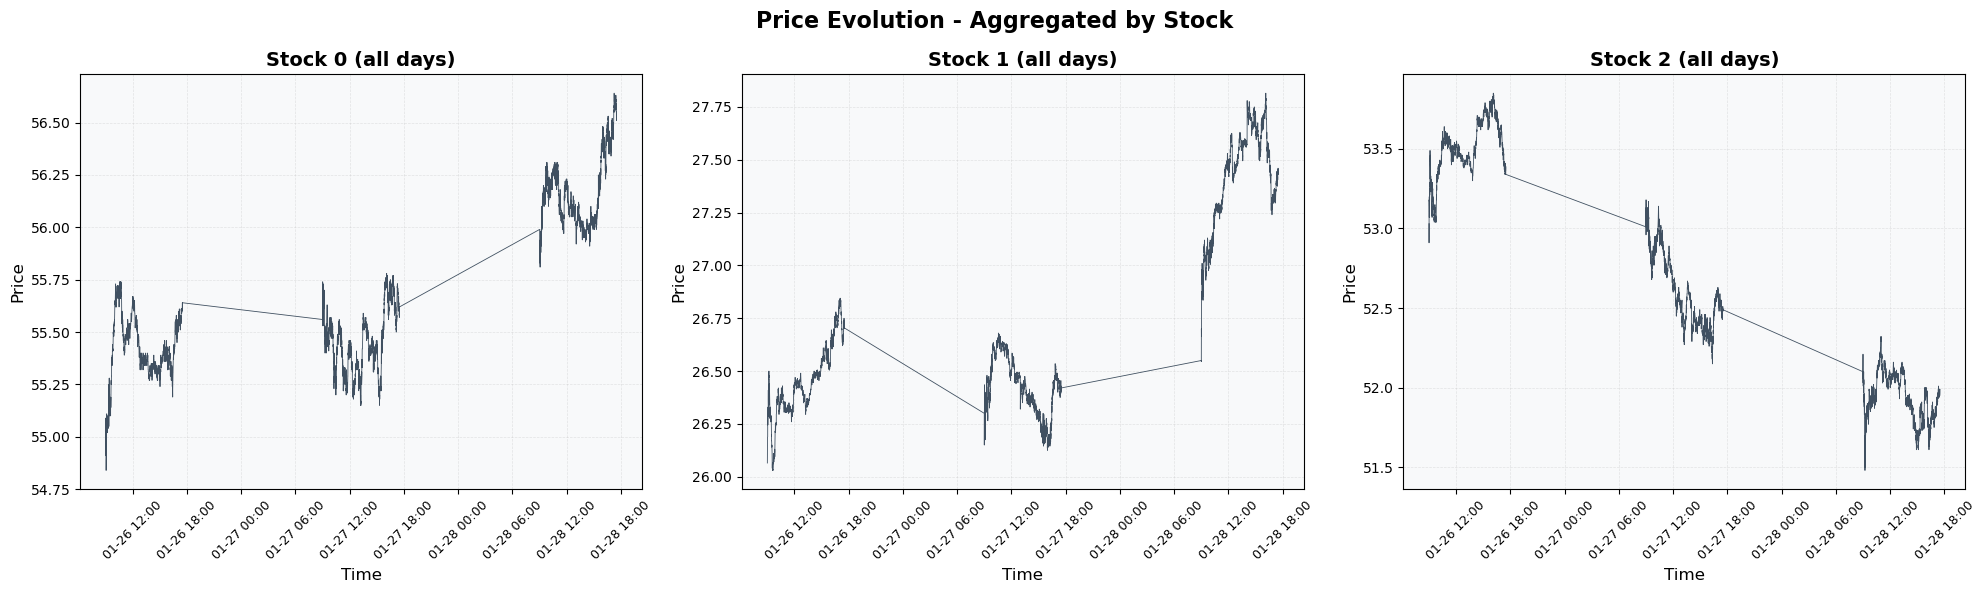

In [19]:
print("\n6. Évolution des prix par stock (tous jours agrégés)...")

# Agréger par stock
stock0_all = pd.concat([df0_j0, df0_j1, df0_j2]).sort_index()
stock1_all = pd.concat([df1_j0, df1_j1, df1_j2]).sort_index()
stock2_all = pd.concat([df2_j0, df2_j1, df2_j2]).sort_index()

stocks_aggregated = {
    'Stock 0 (all days)': stock0_all,
    'Stock 1 (all days)': stock1_all,
    'Stock 2 (all days)': stock2_all
}

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, (stock_name, df) in enumerate(stocks_aggregated.items()):
    if 'price' in df.columns:
        axes[idx].plot(df.index, df['price'], linewidth=0.6, color='#2C3E50', alpha=0.9)
        axes[idx].set_title(f'{stock_name}', fontsize=14, fontweight='bold')
        axes[idx].set_xlabel('Time', fontsize=12)
        axes[idx].set_ylabel('Price', fontsize=12)
        axes[idx].grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
        axes[idx].set_facecolor('#F8F9FA')
        axes[idx].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
        axes[idx].tick_params(axis='x', rotation=45, labelsize=9)

plt.suptitle('Price Evolution - Aggregated by Stock', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [20]:
print(f"\n{'='*70}")
print(f"RÉSUMÉ COMPARATIF - TOUS LES DATASETS")
print(f"{'='*70}\n")

summary = []
for name, df in all_dfs.items():
    stats_dict = {
        'Dataset': name,
        'Trades': f"{len(df):,}",
        'Missing': df.isna().sum().sum(),
        'Duplicates': df.duplicated().sum()
    }
    
    if 'price' in df.columns:
        stats_dict['Mean_Price'] = f"{df['price'].mean():.4f}"
        stats_dict['Std_Price'] = f"{df['price'].std():.4f}"
    
    if 'qty' in df.columns:
        stats_dict['Mean_Qty'] = f"{df['qty'].mean():.2f}"
        stats_dict['Total_Qty'] = f"{df['qty'].sum():.0f}"
    
    summary.append(stats_dict)

summary_df = pd.DataFrame(summary)
print(summary_df.to_string(index=False))


RÉSUMÉ COMPARATIF - TOUS LES DATASETS

    Dataset Trades  Missing  Duplicates Mean_Price Std_Price Mean_Qty Total_Qty
Stock0_day0 19,076        0       10917    55.4301    0.1654   134.96   2574521
Stock0_day1 21,933        0       13301    55.4764    0.1610   111.68   2449507
Stock0_day2 30,315        0       18679    56.2169    0.1900   143.37   4346132
Stock1_day0  4,927        0         966    26.5116    0.1831   103.65    510679
Stock1_day1  5,941        0        1772    26.3732    0.1384   105.82    628676
Stock1_day2 10,144        0        2443    27.4264    0.2442   153.35   1555605
Stock2_day0  9,500        0        4923    53.5026    0.1819   104.86    996184
Stock2_day1 11,466        0        5780    52.5595    0.2240   105.63   1211200
Stock2_day2 13,178        0        6960    51.9144    0.1468   115.55   1522765


In [21]:
print(f"\n{'='*70}")
print(f"COMPARAISON PAR STOCK (tous jours agrégés)")
print(f"{'='*70}\n")

# Agréger par stock
stock0_all = pd.concat([df0_j0, df0_j1, df0_j2]).sort_index()
stock1_all = pd.concat([df1_j0, df1_j1, df1_j2]).sort_index()
stock2_all = pd.concat([df2_j0, df2_j1, df2_j2]).sort_index()

stocks_aggregated = {
    'Stock0': stock0_all,
    'Stock1': stock1_all,
    'Stock2': stock2_all
}

for stock_name, df in stocks_aggregated.items():
    print(f"\n{stock_name}:")
    print(f"  Total trades: {len(df):,}")
    
    if 'price' in df.columns:
        print(f"  Prix moyen: {df['price'].mean():.4f}")
        print(f"  Prix std: {df['price'].std():.4f}")
        print(f"  Prix min: {df['price'].min():.4f}")
        print(f"  Prix max: {df['price'].max():.4f}")
    
    if 'qty' in df.columns:
        print(f"  Quantité moyenne: {df['qty'].mean():.2f}")
        print(f"  Quantité totale: {df['qty'].sum():.0f}")


COMPARAISON PAR STOCK (tous jours agrégés)


Stock0:
  Total trades: 71,324
  Prix moyen: 55.7788
  Prix std: 0.4157
  Prix min: 54.8400
  Prix max: 56.6400
  Quantité moyenne: 131.37
  Quantité totale: 9370160

Stock1:
  Total trades: 21,012
  Prix moyen: 26.9141
  Prix std: 0.5381
  Prix min: 26.0300
  Prix max: 27.8150
  Quantité moyenne: 128.26
  Quantité totale: 2694960

Stock2:
  Total trades: 34,144
  Prix moyen: 52.5729
  Prix std: 0.6650
  Prix min: 51.4800
  Prix max: 53.8500
  Quantité moyenne: 109.25
  Quantité totale: 3730149


## 1.2 Tick size

Tick size is defined as the minimum increment in the price of an asset

In [22]:
print(f"\n{'='*70}")
print(f"1.2 ANALYSE DES TICK SIZES")
print(f"{'='*70}\n")

# Analyser le tick size pour chaque dataset
tick_results = []

for name, df in all_dfs.items():
    if 'price' not in df.columns:
        continue
    
    print(f"\n{name}:")
    print("-" * 50)
    
    # Calculer le tick size (plus petit changement de prix non-nul)
    tick_size = df['price'].diff().abs().replace(0, np.nan).min()
    print(f"  Tick size: {tick_size}")
    
    # Analyser les changements de prix
    price_changes = df['price'].diff().dropna()
    non_zero_changes = price_changes[price_changes != 0]
    
    # Vérifier si tous les changements sont des multiples du tick size
    multiples = non_zero_changes / tick_size
    is_valid = np.allclose(multiples, multiples.round(), rtol=1e-5)
    
    print(f"  Tick size valide (tous les changements sont des multiples): {is_valid}")
    print(f"  Exemples de multiples: {multiples.head(10).values}")
    
    # Statistiques sur les multiples
    print(f"\n  Statistiques des multiples du tick size:")
    print(f"    Moyenne: {multiples.mean():.2f}")
    print(f"    Médiane: {multiples.median():.2f}")
    print(f"    Min: {multiples.min():.2f}")
    print(f"    Max: {multiples.max():.2f}")
    
    # Distribution des multiples les plus fréquents
    multiples_rounded = multiples.round()
    top_multiples = multiples_rounded.value_counts().head(10)
    print(f"\n  Top 10 multiples les plus fréquents:")
    for mult, count in top_multiples.items():
        pct = 100 * count / len(multiples_rounded)
        print(f"    {mult:.0f} tick(s): {count:,} occurrences ({pct:.2f}%)")
    
    # Stocker les résultats
    tick_results.append({
        'Dataset': name,
        'Tick_Size': tick_size,
        'Valid': is_valid,
        'Mean_Multiple': multiples.mean(),
        'Median_Multiple': multiples.median(),
        'Most_Common_Multiple': top_multiples.index[0] if len(top_multiples) > 0 else np.nan
    })



1.2 ANALYSE DES TICK SIZES


Stock0_day0:
--------------------------------------------------
  Tick size: 0.00999999999999801
  Tick size valide (tous les changements sont des multiples): True
  Exemples de multiples: [-3. -2.  2. -1. -1. -2.  1.  1.  1.  1.]

  Statistiques des multiples du tick size:
    Moyenne: 0.02
    Médiane: 1.00
    Min: -4.00
    Max: 5.00

  Top 10 multiples les plus fréquents:
    1 tick(s): 1,330 occurrences (46.93%)
    -1 tick(s): 1,276 occurrences (45.02%)
    2 tick(s): 99 occurrences (3.49%)
    -2 tick(s): 92 occurrences (3.25%)
    -3 tick(s): 17 occurrences (0.60%)
    3 tick(s): 10 occurrences (0.35%)
    4 tick(s): 6 occurrences (0.21%)
    -4 tick(s): 3 occurrences (0.11%)
    5 tick(s): 1 occurrences (0.04%)

Stock0_day1:
--------------------------------------------------
  Tick size: 0.00999999999999801
  Tick size valide (tous les changements sont des multiples): True
  Exemples de multiples: [ 3. -2.  2.  1. -1.  1.  2.  3.  2.  1.]

  Stat

To verify if we computed the right number we check that all prices variations are multiple of the tick

In [23]:
print(f"\n{'='*70}")
print(f"RÉSUMÉ COMPARATIF - TICK SIZES")
print(f"{'='*70}\n")

tick_summary = pd.DataFrame(tick_results)
print(tick_summary.to_string(index=False))


RÉSUMÉ COMPARATIF - TICK SIZES

    Dataset  Tick_Size  Valid  Mean_Multiple  Median_Multiple  Most_Common_Multiple
Stock0_day0      0.010   True       0.022583              1.0                   1.0
Stock0_day1      0.010   True       0.001569             -1.0                  -1.0
Stock0_day2      0.010   True       0.012675              1.0                   1.0
Stock1_day0      0.005   True       0.067016              1.0                   1.0
Stock1_day1      0.005   True       0.009006             -1.0                  -1.0
Stock1_day2      0.005   True       0.052570              1.0                   1.0
Stock2_day0      0.010   True       0.013747             -1.0                  -1.0
Stock2_day1      0.010   True      -0.017693             -1.0                  -1.0
Stock2_day2      0.010   True      -0.003477             -1.0                  -1.0



VISUALISATION DES DISTRIBUTIONS DE TICK SIZES



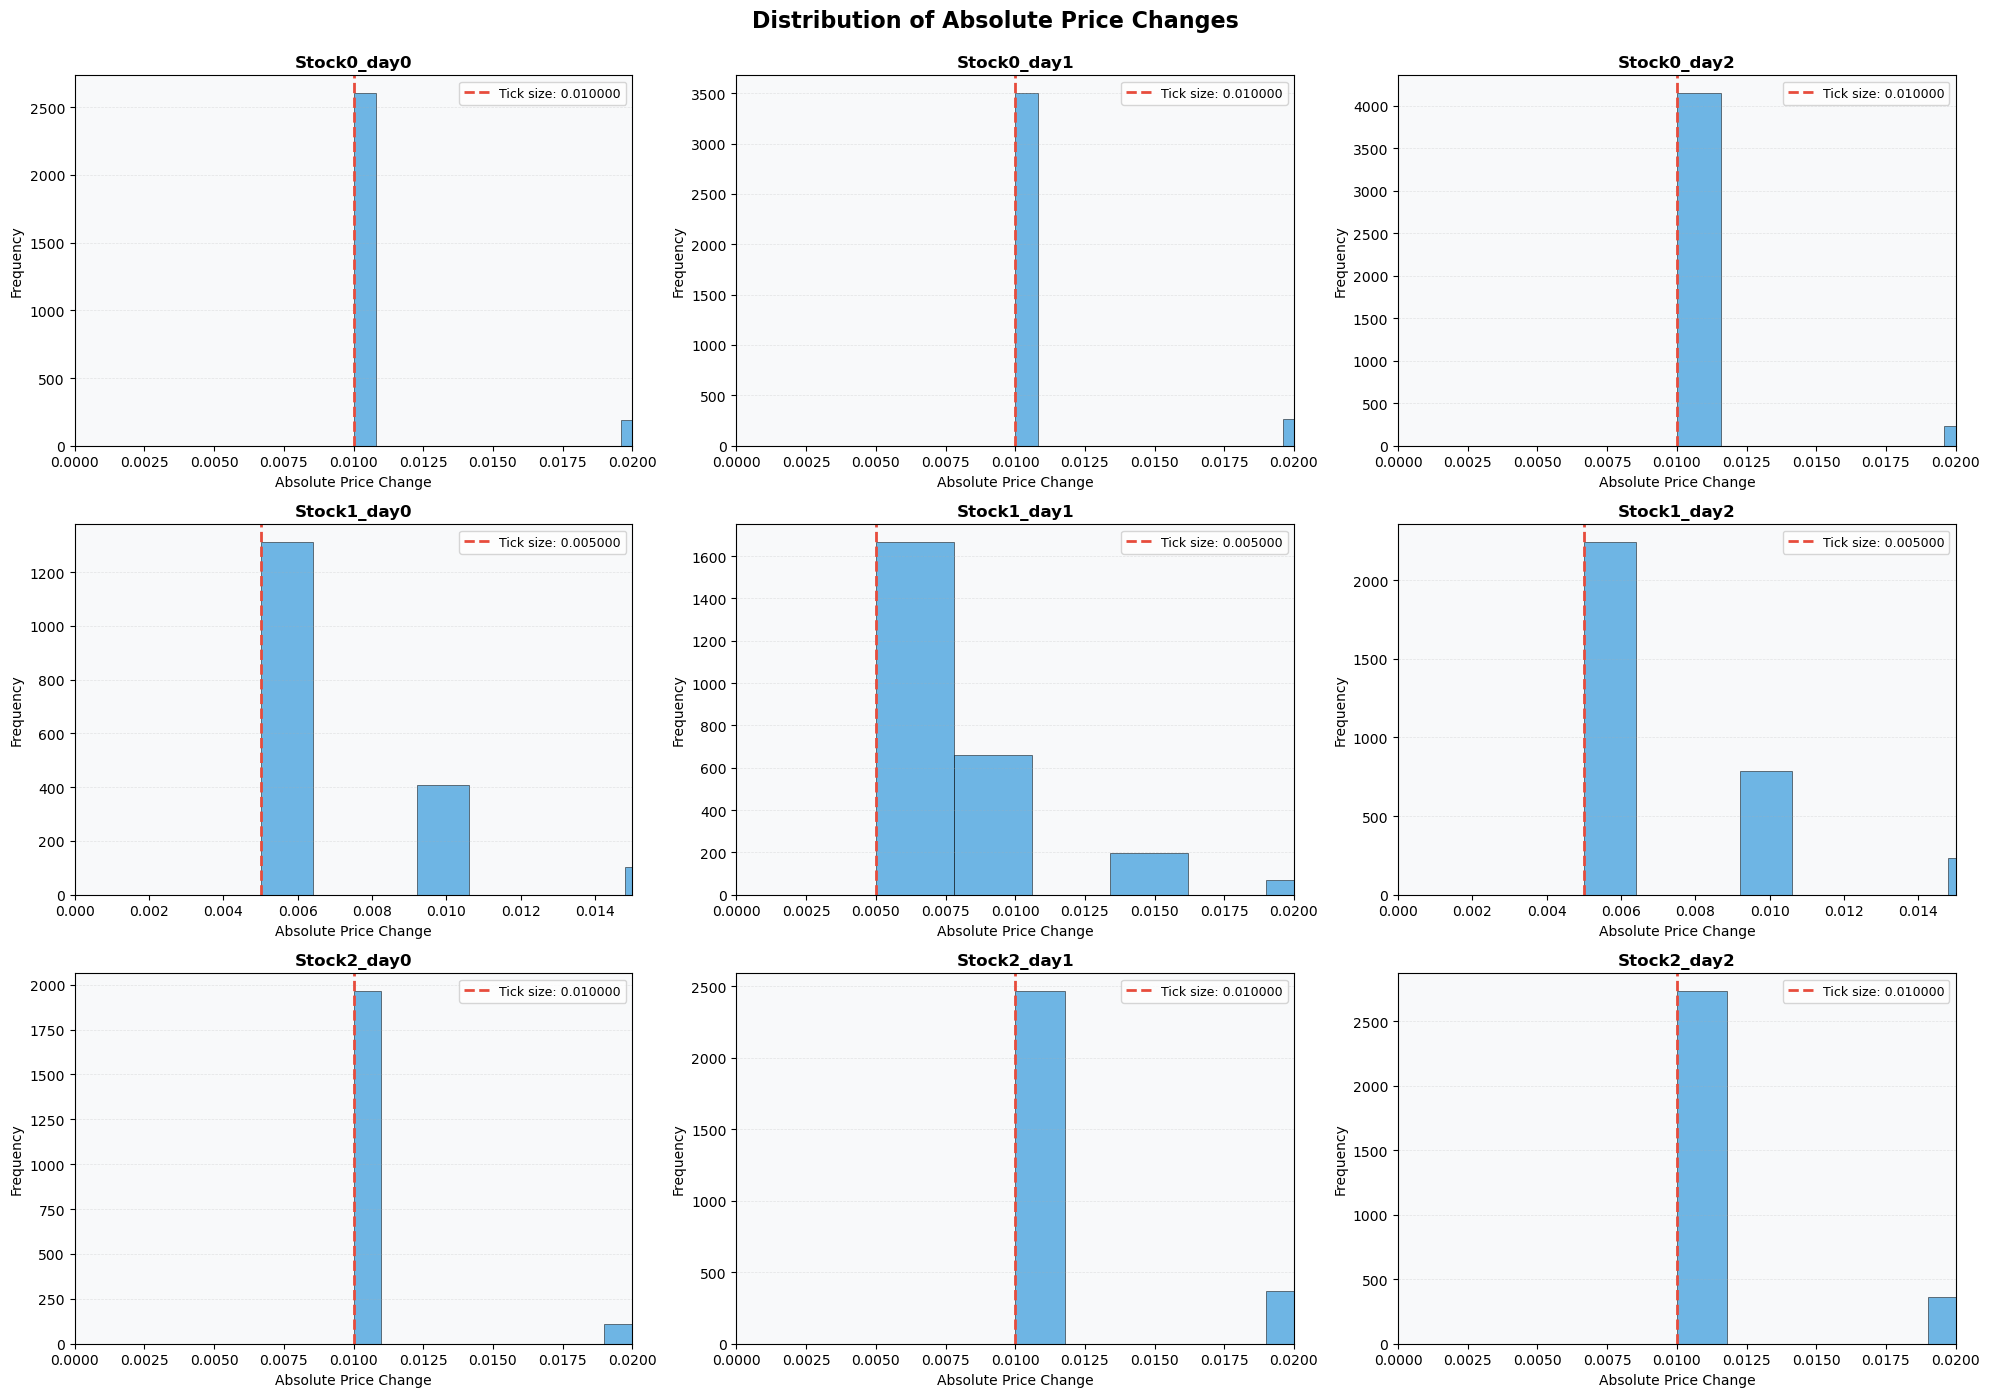

In [24]:
print(f"\n{'='*70}")
print(f"VISUALISATION DES DISTRIBUTIONS DE TICK SIZES")
print(f"{'='*70}\n")

fig, axes = plt.subplots(3, 3, figsize=(20, 14))
axes = axes.flatten()

for idx, (name, df) in enumerate(all_dfs.items()):
    if 'price' in df.columns:
        price_changes = df['price'].diff().dropna()
        non_zero_changes = price_changes[price_changes != 0].abs()
        
        # Histogramme des changements de prix absolus
        axes[idx].hist(non_zero_changes, bins=50, alpha=0.7, 
                      color='#3498DB', edgecolor='black', linewidth=0.5)
        
        tick_size = non_zero_changes.min()
        axes[idx].axvline(tick_size, color='#E74C3C', linestyle='--', linewidth=2,
                         label=f'Tick size: {tick_size:.6f}')
        
        axes[idx].set_title(f'{name}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Absolute Price Change', fontsize=10)
        axes[idx].set_ylabel('Frequency', fontsize=10)
        axes[idx].grid(True, alpha=0.3, linestyle='--', linewidth=0.5, axis='y')
        axes[idx].set_facecolor('#F8F9FA')
        axes[idx].legend(fontsize=9)
        axes[idx].set_xlim(0, non_zero_changes.quantile(0.95))  # Zoom sur 95% des données

plt.suptitle('Distribution of Absolute Price Changes', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [25]:
print(f"\n{'='*70}")
print(f"TICK SIZE PAR STOCK (tous jours agrégés)")
print(f"{'='*70}\n")

stock0_all = pd.concat([df0_j0, df0_j1, df0_j2]).sort_index()
stock1_all = pd.concat([df1_j0, df1_j1, df1_j2]).sort_index()
stock2_all = pd.concat([df2_j0, df2_j1, df2_j2]).sort_index()

stocks_aggregated = {
    'Stock 0': stock0_all,
    'Stock 1': stock1_all,
    'Stock 2': stock2_all
}

for stock_name, df in stocks_aggregated.items():
    print(f"\n{stock_name}:")
    print("-" * 50)
    
    tick_size = df['price'].diff().abs().replace(0, np.nan).min()
    print(f"  Tick size global: {tick_size}")
    
    price_changes = df['price'].diff().dropna()
    non_zero_changes = price_changes[price_changes != 0]
    multiples = non_zero_changes / tick_size
    is_valid = np.allclose(multiples, multiples.round(), rtol=1e-5)
    
    print(f"  Tick size valide: {is_valid}")
    print(f"  Nombre de trades: {len(df):,}")
    print(f"  Changements de prix: {len(non_zero_changes):,}")
    print(f"  Prix constant (no change): {len(price_changes[price_changes == 0]):,}")


TICK SIZE PAR STOCK (tous jours agrégés)


Stock 0:
--------------------------------------------------
  Tick size global: 0.00999999999999801
  Tick size valide: True
  Nombre de trades: 71,324
  Changements de prix: 11,077
  Prix constant (no change): 60,246

Stock 1:
--------------------------------------------------
  Tick size global: 0.004999999999999005
  Tick size valide: True
  Nombre de trades: 21,012
  Changements de prix: 8,001
  Prix constant (no change): 13,010

Stock 2:
--------------------------------------------------
  Tick size global: 0.00999999999999801
  Tick size valide: True
  Nombre de trades: 34,144
  Changements de prix: 8,360
  Prix constant (no change): 25,783


## 1.2 Commentary on Tick Sizes

### Main Observations

#### 1. **Identified tick sizes**
- **Stock 0**: tick size = **0.01** (1 cent)
- **Stock 1**: tick size = **0.005** (0.5 cent)
- **Stock 2**: tick size = **0.01** (1 cent)

The tick size is **consistent** for a given stock across all trading days, which is expected since tick size is a market rule that does not change daily.

#### 2. **Tick size validity**
**All datasets show 100% validity**: every observed price change is an exact multiple of the tick size. This confirms that:
- The data quality is high
- No significant rounding errors
- The market strictly respects tick size rules

#### 3. **Distribution of price changes**

**Observations common to all stocks:**
- **~90-95% of changes** are **±1 tick** (minimum movement)
- Changes of 2 ticks represent ~3-12% of cases
- Changes ≥3 ticks are rare (<2% of cases)

**Typical pattern of a liquid high-frequency market**: the majority of trades occur at the best available price, generating minimal movements.

#### 4. **Differences between stocks**

| Characteristic | Stock 0 | Stock 1 | Stock 2 |
|----------------|---------|---------|---------|
| **Tick size** | 0.01 | **0.005** | 0.01 |
| **Changes ±1 tick** | ~92% | **~65%** | ~87% |
| **Changes ±2 ticks** | ~7% | **~23%** | ~11% |
| **Relative volatility** | Low | **High** | Medium |

**Stock 1** stands out with:
- A tick size **2× smaller** (0.005 vs 0.01)
- A **more dispersed distribution** of multiples (up to ±29 ticks observed)
- A higher proportion of 2+ tick changes (~35% vs ~8% for Stock 0)
- Suggests a **more volatile** or less liquid asset

#### 5. **Proportion of constant prices**

Significant proportion of trades **without price changes**:
- **Stock 0**: 84.5% of trades (60,246 / 71,324)
- **Stock 1**: 61.9% of trades (13,010 / 21,012)
- **Stock 2**: 75.5% of trades (25,783 / 34,144)

**Expected in HF trading**: multiple trades can execute at the same price (within the bid-ask spread) before the price moves.

#### 6. **Movement asymmetry**

The **median of multiples** indicates a slight directional tendency varying by day:
- Some days median = +1 (intraday upward trend)
- Other days median = -1 (intraday downward trend)
- Mean close to 0 confirms the absence of systematic drift

### Conclusion

All tick sizes are compliant and consistent. No anomalies detected - all changes are exact multiples. Typical behavior of a high-frequency market with predominance of minimal movements (±1 tick).

**Stock 1** presents distinct characteristics (finer tick, greater volatility) which could reflect:
- An asset with lower unit price
- Different listing rules
- Different market microstructure (less liquidity at the best price)

The data is **clean and suitable** for further market microstructure analysis.

## 1.3 Intraday activity

1. Activité intraday pour chaque dataset (médiane volume 2min)...


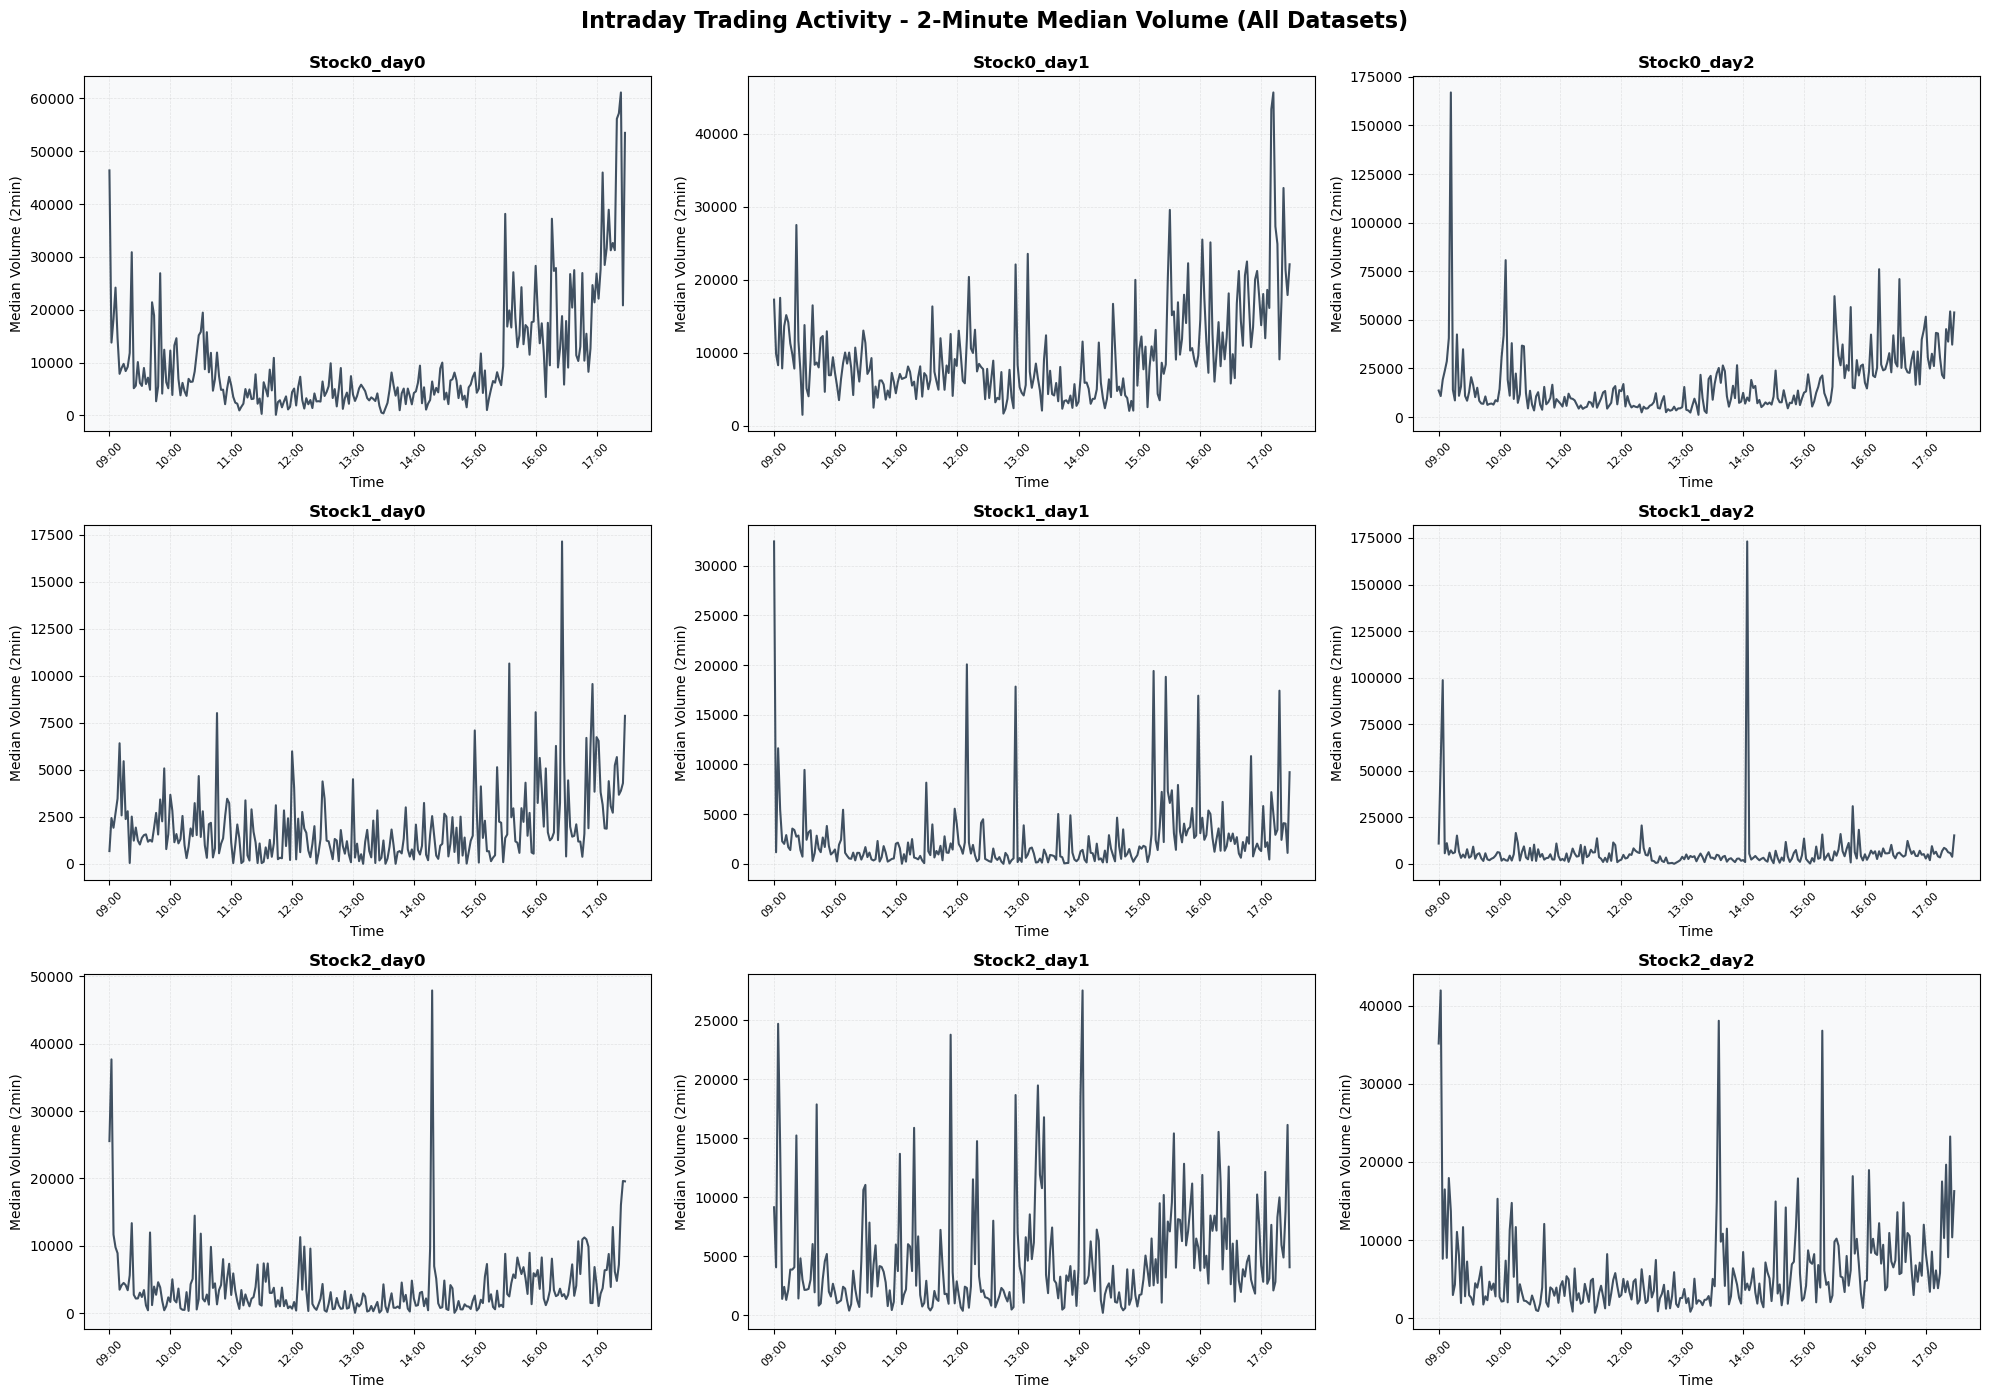

In [26]:
print("1. Activité intraday pour chaque dataset (médiane volume 2min)...")

fig, axes = plt.subplots(3, 3, figsize=(20, 14))
axes = axes.flatten()

for idx, (name, df) in enumerate(all_dfs.items()):
    if 'qty' in df.columns:
        # Resampler à 2 minutes et calculer la médiane
        volume_2min = df['qty'].resample('2min').sum()
        
        axes[idx].plot(volume_2min.index, volume_2min.values, 
                      linewidth=1.5, color='#2C3E50', alpha=0.9)
        axes[idx].set_title(f'{name}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Time', fontsize=10)
        axes[idx].set_ylabel('Median Volume (2min)', fontsize=10)
        axes[idx].grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
        axes[idx].set_facecolor('#F8F9FA')
        axes[idx].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        axes[idx].tick_params(axis='x', rotation=45, labelsize=8)

plt.suptitle('Intraday Trading Activity - 2-Minute Median Volume (All Datasets)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


3. Pattern intraday moyen par heure...


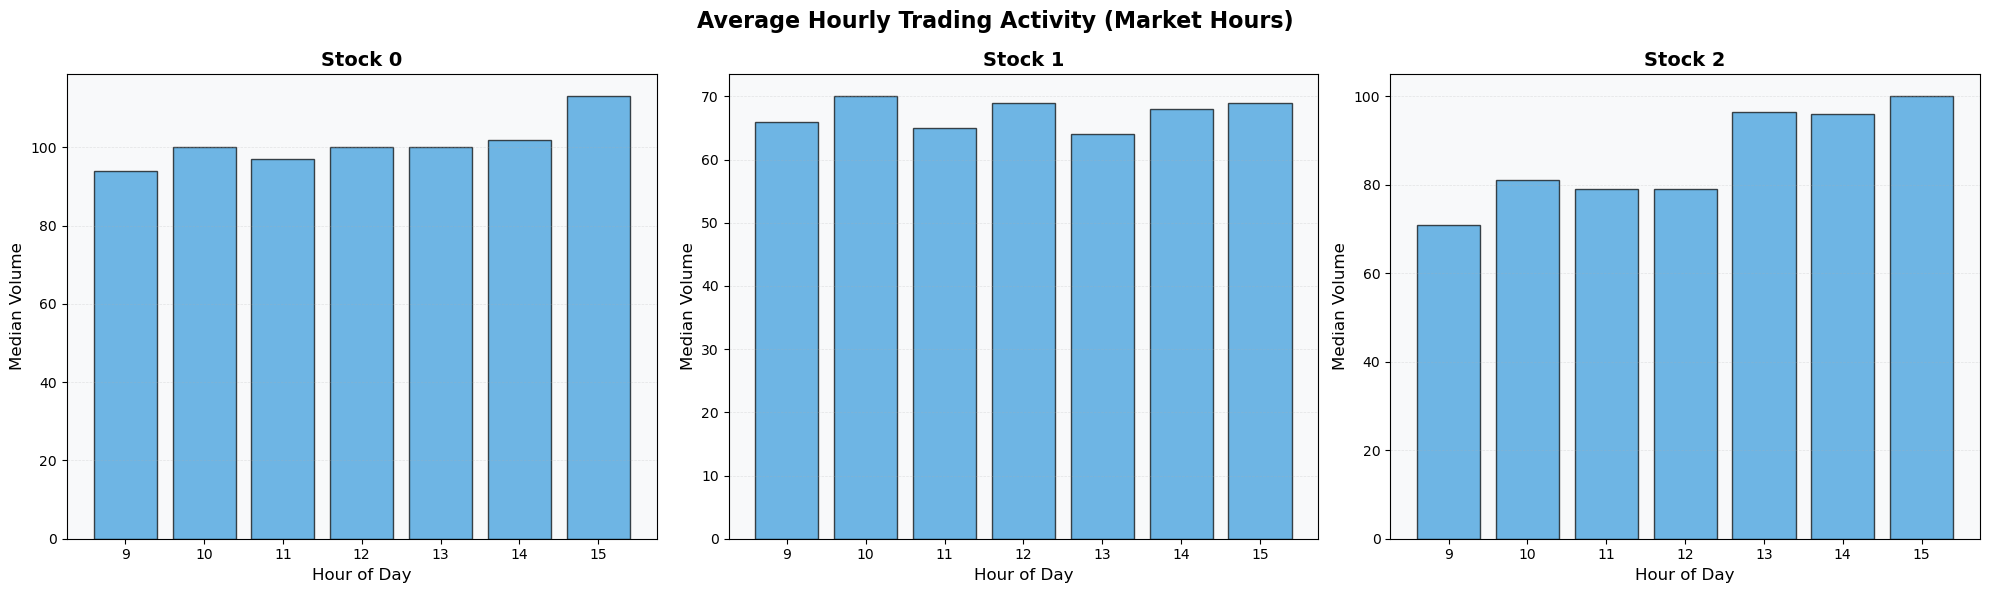

In [27]:
print("\n3. Pattern intraday moyen par heure...")

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, (stock_name, df) in enumerate(stocks_aggregated.items()):
    if 'qty' in df.columns:
        # Filtrer heures de marché
        df_market = df.between_time('09:30', '16:00')
        
        # Grouper par heure et calculer la médiane des volumes
        hourly_volume = df_market.groupby(df_market.index.hour)['qty'].median()
        
        axes[idx].bar(hourly_volume.index, hourly_volume.values,
                     alpha=0.7, color='#3498DB', edgecolor='black', linewidth=1)
        axes[idx].set_title(f'{stock_name}', fontsize=14, fontweight='bold')
        axes[idx].set_xlabel('Hour of Day', fontsize=12)
        axes[idx].set_ylabel('Median Volume', fontsize=12)
        axes[idx].grid(True, alpha=0.3, linestyle='--', linewidth=0.5, axis='y')
        axes[idx].set_facecolor('#F8F9FA')
        axes[idx].set_xticks(hourly_volume.index)

plt.suptitle('Average Hourly Trading Activity (Market Hours)',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


4. Nombre de trades par intervalle de 2 minutes (par jour)...


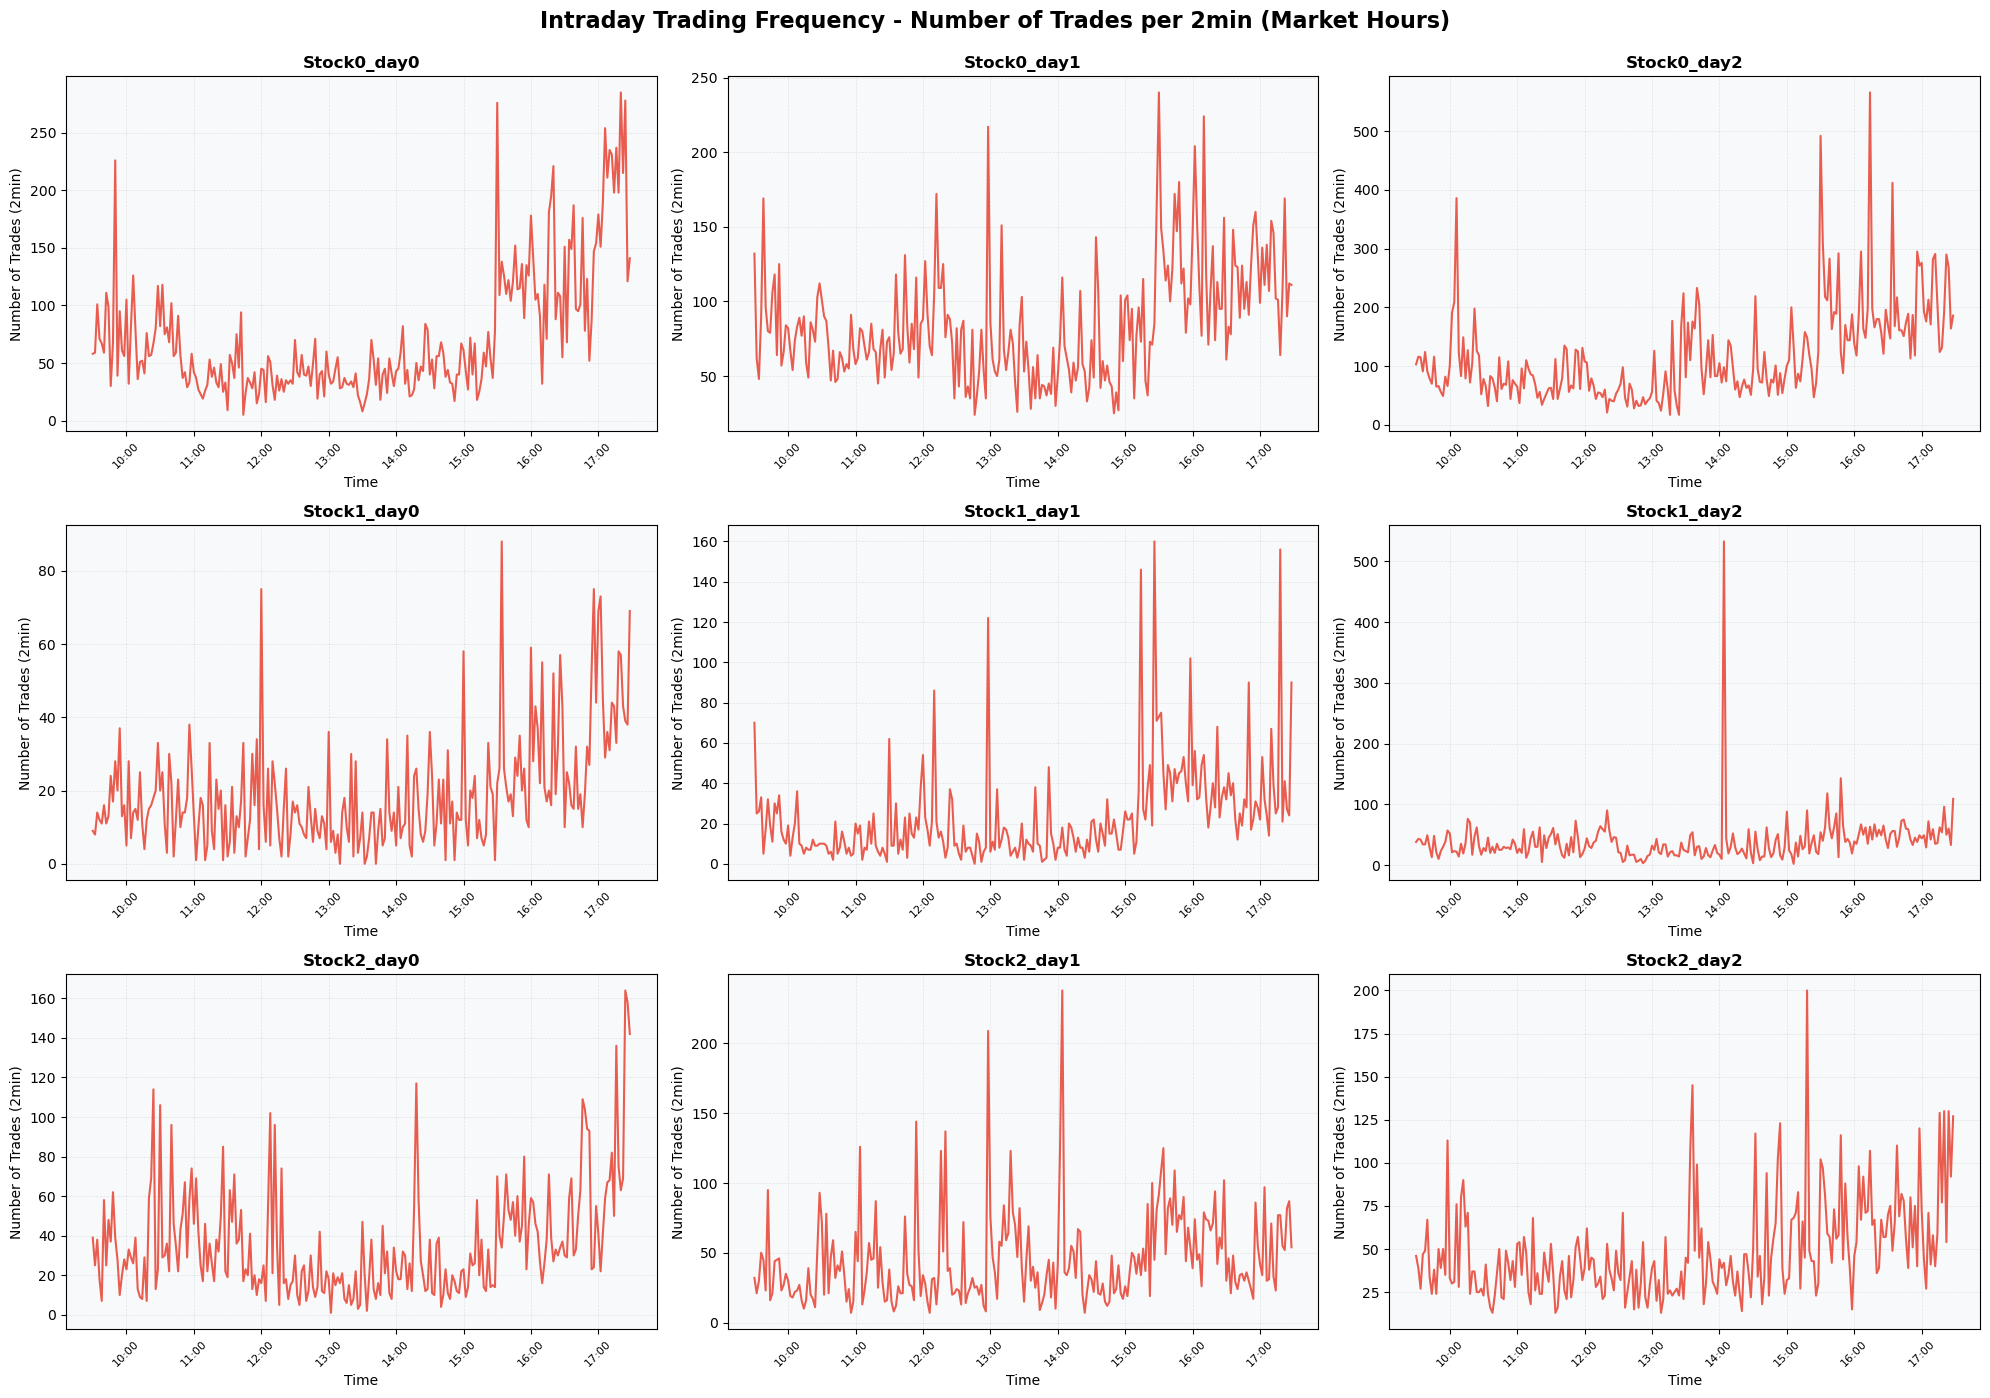

In [31]:
print("\n4. Nombre de trades par intervalle de 2 minutes (par jour)...")

fig, axes = plt.subplots(3, 3, figsize=(20, 14))
axes = axes.flatten()

for idx, (name, df) in enumerate(all_dfs.items()):
    # Filtrer heures de marché
    df_market = df.between_time('09:30', '17:30')
    
    # Compter le nombre de trades par intervalle de 2 minutes
    trades_2min = df_market.resample('2min').size()
    
    axes[idx].plot(trades_2min.index, trades_2min.values,
                  linewidth=1.5, color='#E74C3C', alpha=0.9)
    axes[idx].set_title(f'{name}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Time', fontsize=10)
    axes[idx].set_ylabel('Number of Trades (2min)', fontsize=10)
    axes[idx].grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    axes[idx].set_facecolor('#F8F9FA')
    axes[idx].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    axes[idx].tick_params(axis='x', rotation=45, labelsize=8)

plt.suptitle('Intraday Trading Frequency - Number of Trades per 2min (Market Hours)',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

We see that the curve depend on the stock. We do not clearly retrieve the U-Shape expected and for european stock we do not clearly see the opening of American Market for every stock. 

In [29]:
print(f"\n{'='*70}")
print(f"ANALYSE STATISTIQUE - PATTERN EN U")
print(f"{'='*70}\n")

for stock_name, df in stocks_aggregated.items():
    print(f"\n{stock_name}:")
    print("-" * 50)
    
    # Filtrer heures de marché
    df_market = df.between_time('09:30', '16:00')
    
    # Diviser en 3 périodes
    morning_open = df_market.between_time('09:30', '10:30')
    midday = df_market.between_time('11:00', '15:00')
    afternoon_close = df_market.between_time('15:00', '16:00')
    
    if 'qty' in df.columns:
        # Volume médian par période
        vol_morning = morning_open['qty'].median()
        vol_midday = midday['qty'].median()
        vol_afternoon = afternoon_close['qty'].median()
        
        print(f"  Median Volume:")
        print(f"    Morning (9:30-10:30):   {vol_morning:.2f}")
        print(f"    Midday (11:00-15:00):   {vol_midday:.2f}")
        print(f"    Close (15:00-16:00):    {vol_afternoon:.2f}")
        
        # Ratio U-shape
        u_ratio = (vol_morning + vol_afternoon) / (2 * vol_midday)
        print(f"    U-shape ratio: {u_ratio:.2f} (>1 indicates U-shape)")
    
    # Nombre de trades par période
    trades_morning = len(morning_open)
    trades_midday = len(midday)
    trades_afternoon = len(afternoon_close)
    
    print(f"\n  Number of Trades:")
    print(f"    Morning (9:30-10:30):   {trades_morning:,}")
    print(f"    Midday (11:00-15:00):   {trades_midday:,}")
    print(f"    Close (15:00-16:00):    {trades_afternoon:,}")
    
    trades_per_hour_morning = trades_morning / 1.0  # 1 hour
    trades_per_hour_midday = trades_midday / 4.0    # 4 hours
    trades_per_hour_afternoon = trades_afternoon / 1.0  # 1 hour
    
    print(f"\n  Trades per Hour:")
    print(f"    Morning:   {trades_per_hour_morning:,.0f}")
    print(f"    Midday:    {trades_per_hour_midday:,.0f}")
    print(f"    Afternoon: {trades_per_hour_afternoon:,.0f}")


print("\n" + "="*70)
print("INTERPRETATION GUIDE:")
print("="*70)
print("U-shaped pattern characteristics:")
print("  - High activity at market open (9:30-10:30)")
print("  - Lower activity during midday (11:00-15:00)")
print("  - High activity at market close (15:00-16:00)")
print("  - U-shape ratio > 1.0 indicates presence of U-shape")
print("="*70)

print("\n✓ Analyse de l'activité intraday terminée")


ANALYSE STATISTIQUE - PATTERN EN U


Stock 0:
--------------------------------------------------
  Median Volume:
    Morning (9:30-10:30):   97.00
    Midday (11:00-15:00):   100.00
    Close (15:00-16:00):    113.00
    U-shape ratio: 1.05 (>1 indicates U-shape)

  Number of Trades:
    Morning (9:30-10:30):   8,220
    Midday (11:00-15:00):   22,521
    Close (15:00-16:00):    10,810

  Trades per Hour:
    Morning:   8,220
    Midday:    5,630
    Afternoon: 10,810

Stock 1:
--------------------------------------------------
  Median Volume:
    Morning (9:30-10:30):   68.00
    Midday (11:00-15:00):   66.00
    Close (15:00-16:00):    69.00
    U-shape ratio: 1.04 (>1 indicates U-shape)

  Number of Trades:
    Morning (9:30-10:30):   2,078
    Midday (11:00-15:00):   7,378
    Close (15:00-16:00):    3,473

  Trades per Hour:
    Morning:   2,078
    Midday:    1,844
    Afternoon: 3,473

Stock 2:
--------------------------------------------------
  Median Volume:
    Morning (9

In [30]:
trade_durations = df0.index.to_series().diff().dt.total_seconds()
trade_durations = trade_durations.dropna()  

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].hist(trade_durations, bins=100, density=True, 
             alpha=0.7, color='#3498DB', edgecolor='white', linewidth=0.5)

mean_duration = trade_durations.mean()
median_duration = trade_durations.median()
axes[0].axvline(mean_duration, color='#E74C3C', linestyle='--', 
                linewidth=2, label=f'Mean: {mean_duration:.3f}s')
axes[0].axvline(median_duration, color='#27AE60', linestyle='--', 
                linewidth=2, label=f'Median: {median_duration:.3f}s')

axes[0].set_title('Trade Duration Distribution (Normal Scale)', 
                  fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel('Duration (seconds)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Density', fontsize=11, fontweight='bold')
axes[0].grid(True, alpha=0.3, linestyle='--', linewidth=0.5, axis='y')
axes[0].set_facecolor('#F8F9FA')
axes[0].legend(fontsize=10)

trade_durations_pos = trade_durations[trade_durations > 0]

axes[1].hist(trade_durations_pos, bins=100, density=True, 
             alpha=0.7, color='#9B59B6', edgecolor='white', linewidth=0.5)
axes[1].set_yscale('log')

axes[1].axvline(mean_duration, color='#E74C3C', linestyle='--', 
                linewidth=2, label=f'Mean: {mean_duration:.3f}s')
axes[1].axvline(median_duration, color='#27AE60', linestyle='--', 
                linewidth=2, label=f'Median: {median_duration:.3f}s')

axes[1].set_title('Trade Duration Distribution (Log Scale)', 
                  fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Duration (seconds)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Density (log scale)', fontsize=11, fontweight='bold')
axes[1].grid(True, alpha=0.3, linestyle='--', linewidth=0.5, axis='y')
axes[1].set_facecolor('#F8F9FA')
axes[1].legend(fontsize=10)

plt.tight_layout()
plt.show()

print("=== Trade Duration Statistics ===")
print(f"Mean: {mean_duration:.6f} seconds")
print(f"Median: {median_duration:.6f} seconds")
print(f"Std: {trade_durations.std():.6f} seconds")
print(f"Min: {trade_durations.min():.6f} seconds")
print(f"Max: {trade_durations.max():.6f} seconds")
print(f"\nQuantiles:")
print(trade_durations.quantile([0.25, 0.5, 0.75, 0.95, 0.99]))

NameError: name 'df0' is not defined

1. Distribution des durées entre trades (échelle log-log)...


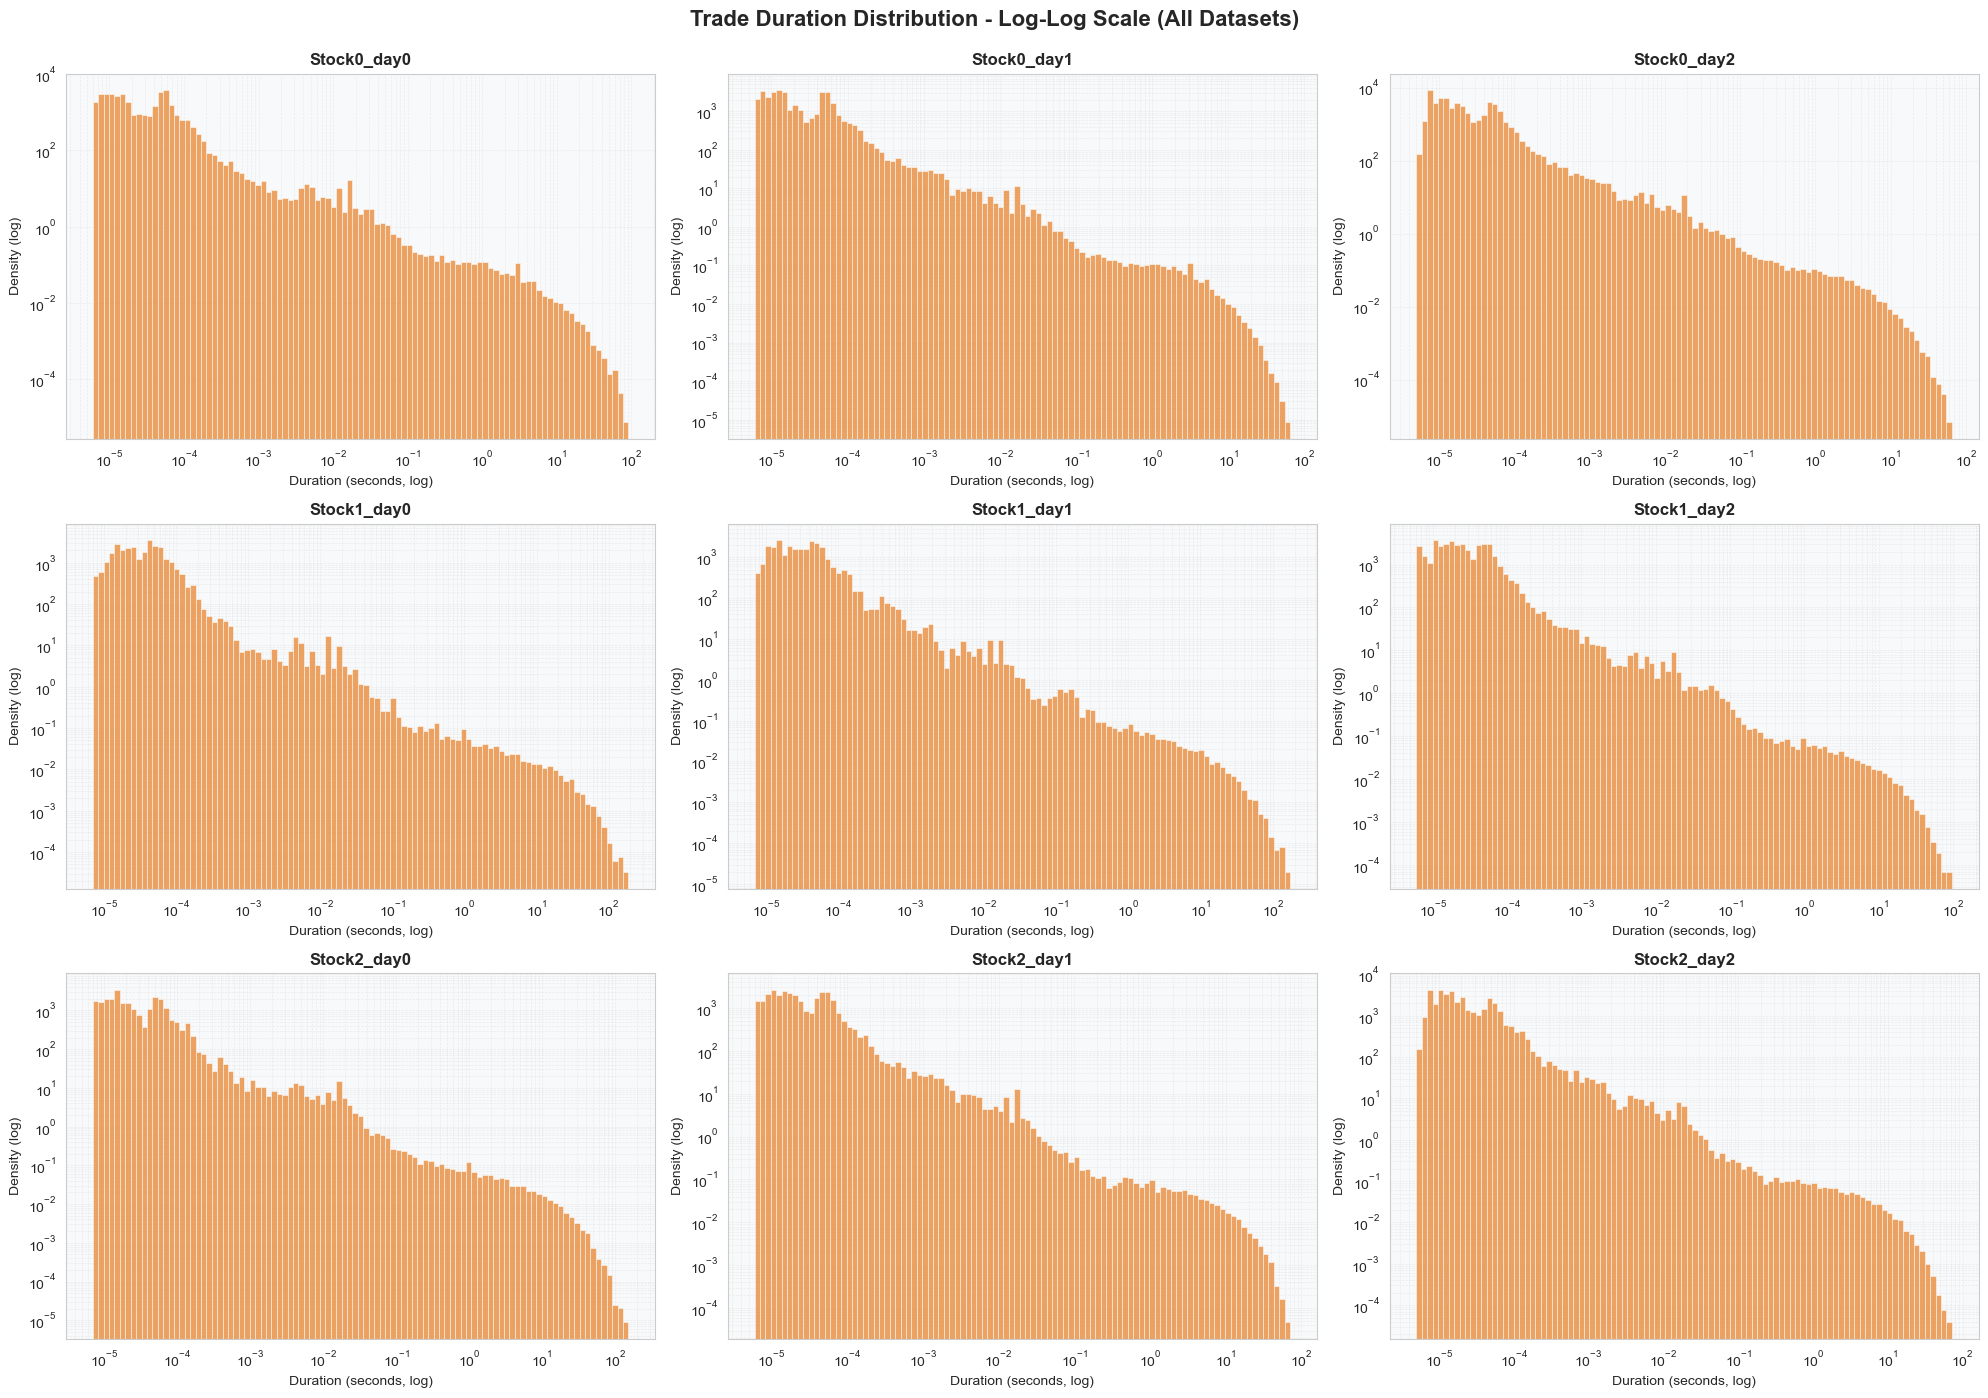

In [ ]:
print("1. Distribution des durées entre trades (échelle log-log)...")

fig, axes = plt.subplots(3, 3, figsize=(20, 14))
axes = axes.flatten()

for idx, (name, df) in enumerate(all_dfs.items()):
    # Calculer les durées entre trades
    trade_durations = df.index.to_series().diff().dt.total_seconds()
    trade_durations_pos = trade_durations[trade_durations > 0]
    
    if len(trade_durations_pos) > 0:
        axes[idx].hist(trade_durations_pos, 
                      bins=np.logspace(np.log10(trade_durations_pos.min()),
                                      np.log10(trade_durations_pos.max()), 
                                      100),
                      density=True, alpha=0.7, color='#E67E22', 
                      edgecolor='white', linewidth=0.5)
        axes[idx].set_xscale('log')
        axes[idx].set_yscale('log')
        axes[idx].set_title(f'{name}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Duration (seconds, log)', fontsize=10)
        axes[idx].set_ylabel('Density (log)', fontsize=10)
        axes[idx].grid(True, alpha=0.3, which='both', linestyle='--', linewidth=0.5)
        axes[idx].set_facecolor('#F8F9FA')

plt.suptitle('Trade Duration Distribution - Log-Log Scale (All Datasets)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


2. Distributions cumulatives des durées entre trades...


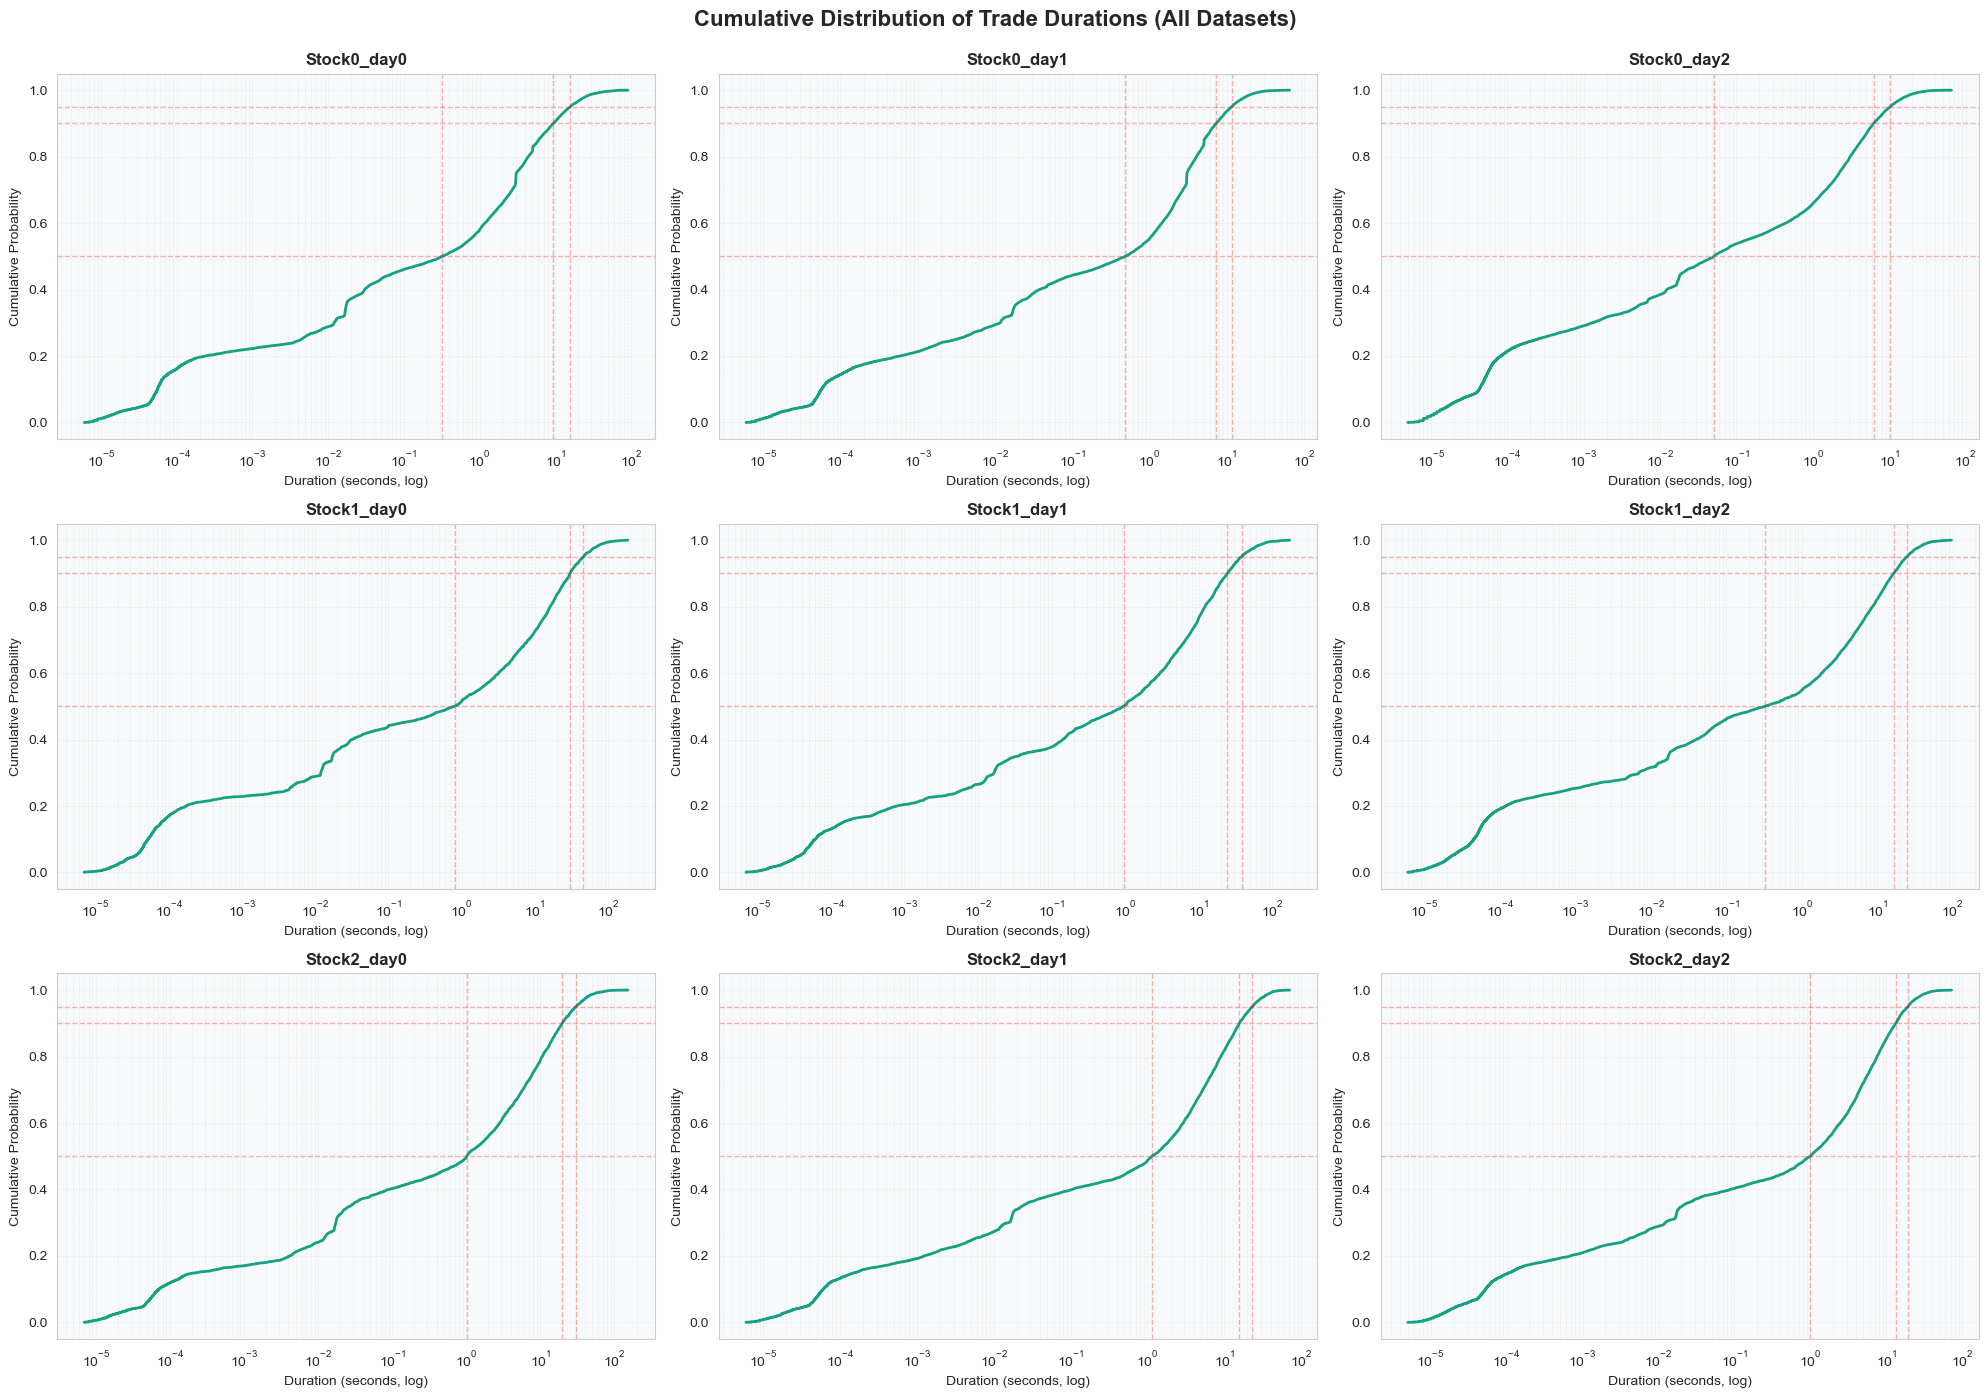

In [ ]:
print("\n2. Distributions cumulatives des durées entre trades...")

fig, axes = plt.subplots(3, 3, figsize=(20, 14))
axes = axes.flatten()

for idx, (name, df) in enumerate(all_dfs.items()):
    # Calculer les durées entre trades
    trade_durations = df.index.to_series().diff().dt.total_seconds()
    trade_durations_pos = trade_durations[trade_durations > 0]
    
    if len(trade_durations_pos) > 0:
        sorted_durations = np.sort(trade_durations_pos)
        cumulative = np.arange(1, len(sorted_durations) + 1) / len(sorted_durations)
        
        axes[idx].plot(sorted_durations, cumulative, linewidth=2, color='#16A085')
        axes[idx].set_xscale('log')
        axes[idx].set_title(f'{name}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Duration (seconds, log)', fontsize=10)
        axes[idx].set_ylabel('Cumulative Probability', fontsize=10)
        axes[idx].grid(True, alpha=0.3, which='both', linestyle='--', linewidth=0.5)
        axes[idx].set_facecolor('#F8F9FA')
        
        # Ajouter les percentiles
        for p in [0.5, 0.9, 0.95]:
            val = np.percentile(sorted_durations, p * 100)
            axes[idx].axhline(p, color='red', linestyle='--', alpha=0.3, linewidth=1)
            axes[idx].axvline(val, color='red', linestyle='--', alpha=0.3, linewidth=1)

plt.suptitle('Cumulative Distribution of Trade Durations (All Datasets)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [ ]:
print(f"\n{'='*70}")
print(f"STATISTIQUES DES DURÉES ENTRE TRADES")
print(f"{'='*70}\n")

duration_stats = []

for name, df in all_dfs.items():
    trade_durations = df.index.to_series().diff().dt.total_seconds()
    trade_durations_pos = trade_durations[trade_durations > 0]
    
    if len(trade_durations_pos) > 0:
        stats = {
            'Dataset': name,
            'Mean (s)': f"{trade_durations_pos.mean():.4f}",
            'Median (s)': f"{trade_durations_pos.median():.4f}",
            'Std (s)': f"{trade_durations_pos.std():.4f}",
            'Min (s)': f"{trade_durations_pos.min():.6f}",
            'Max (s)': f"{trade_durations_pos.max():.2f}",
            'P50 (s)': f"{trade_durations_pos.quantile(0.50):.4f}",
            'P90 (s)': f"{trade_durations_pos.quantile(0.90):.4f}",
            'P95 (s)': f"{trade_durations_pos.quantile(0.95):.4f}",
            'P99 (s)': f"{trade_durations_pos.quantile(0.99):.4f}"
        }
        duration_stats.append(stats)

duration_stats_df = pd.DataFrame(duration_stats)
print(duration_stats_df.to_string(index=False))



STATISTIQUES DES DURÉES ENTRE TRADES

    Dataset Mean (s) Median (s) Std (s)  Min (s) Max (s) P50 (s) P90 (s) P95 (s) P99 (s)
Stock0_day0   3.1952     0.3221  6.8059 0.000006   91.17  0.3221  9.4670 15.8626 33.1728
Stock0_day1   2.5390     0.4866  4.6124 0.000006   64.73  0.4866  7.2589 11.5021 22.1000
Stock0_day2   2.0337     0.0505  4.3402 0.000005   65.22  0.0505  6.2642 10.2464 21.1243
Stock1_day0   9.6970     0.8124 18.5886 0.000007  187.61  0.8124 30.4403 46.1197 87.7710
Stock1_day1   8.0482     0.9515 15.9777 0.000007  172.93  0.9515 24.6231 38.3173 76.7694
Stock1_day2   5.1305     0.3242  9.6301 0.000006   96.11  0.3242 16.4982 24.6404 44.7016
Stock2_day0   6.4569     1.0202 11.8461 0.000007  152.53  1.0202 19.8387 30.3503 54.8558
Stock2_day1   5.1361     1.1426  8.3609 0.000006   70.78  1.1426 15.6752 23.0821 38.4581
Stock2_day2   4.3221     1.0001  7.1525 0.000005   71.94  1.0001 13.2705 19.3081 33.3237



COMPARAISON PAR STOCK (tous jours agrégés)



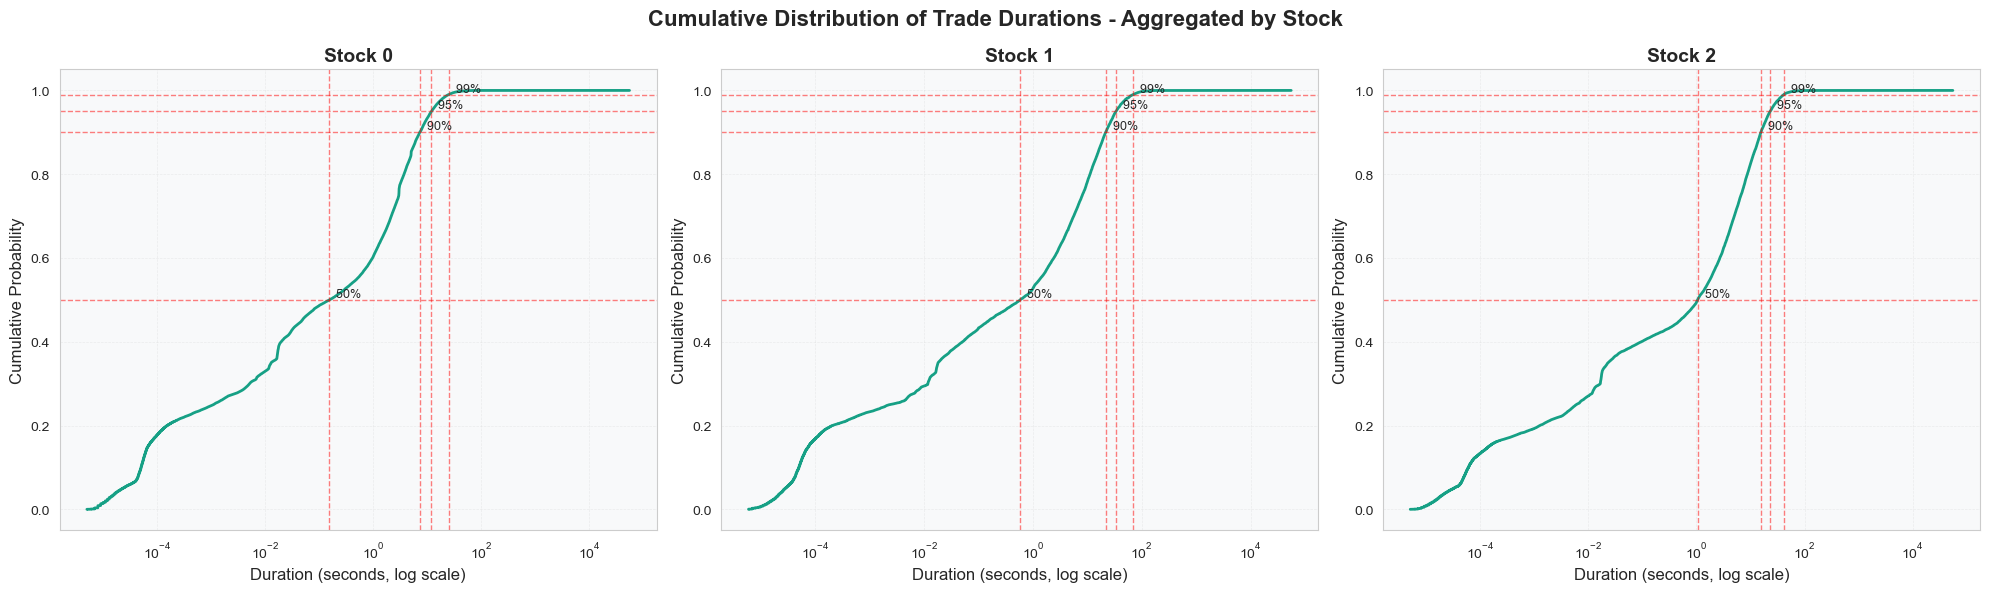


Stock 0:
  Mean duration: 5.5496 seconds
  Median duration: 0.1552 seconds
  P50: 0.1552 s
  P90: 7.2937 s
  P95: 12.0201 s
  P99: 24.9773 s

Stock 1:
  Mean duration: 15.7510 seconds
  Median duration: 0.5862 seconds
  P50: 0.5862 s
  P90: 21.8108 s
  P95: 33.8279 s
  P99: 69.7349 s

Stock 2:
  Mean duration: 11.4479 seconds
  Median duration: 1.0474 seconds
  P50: 1.0474 s
  P90: 15.6075 s
  P95: 23.0766 s
  P99: 41.3645 s


In [ ]:
print(f"\n{'='*70}")
print(f"COMPARAISON PAR STOCK (tous jours agrégés)")
print(f"{'='*70}\n")

stock0_all = pd.concat([df0_j0, df0_j1, df0_j2]).sort_index()
stock1_all = pd.concat([df1_j0, df1_j1, df1_j2]).sort_index()
stock2_all = pd.concat([df2_j0, df2_j1, df2_j2]).sort_index()

stocks_aggregated = {
    'Stock 0': stock0_all,
    'Stock 1': stock1_all,
    'Stock 2': stock2_all
}

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, (stock_name, df) in enumerate(stocks_aggregated.items()):
    trade_durations = df.index.to_series().diff().dt.total_seconds()
    trade_durations_pos = trade_durations[trade_durations > 0]
    
    if len(trade_durations_pos) > 0:
        sorted_durations = np.sort(trade_durations_pos)
        cumulative = np.arange(1, len(sorted_durations) + 1) / len(sorted_durations)
        
        axes[idx].plot(sorted_durations, cumulative, linewidth=2, color='#16A085')
        axes[idx].set_xscale('log')
        axes[idx].set_title(f'{stock_name}', fontsize=14, fontweight='bold')
        axes[idx].set_xlabel('Duration (seconds, log scale)', fontsize=12)
        axes[idx].set_ylabel('Cumulative Probability', fontsize=12)
        axes[idx].grid(True, alpha=0.3, which='both', linestyle='--', linewidth=0.5)
        axes[idx].set_facecolor('#F8F9FA')
        
        # Ajouter les percentiles avec labels
        for p in [0.5, 0.9, 0.95, 0.99]:
            val = np.percentile(sorted_durations, p * 100)
            axes[idx].axhline(p, color='red', linestyle='--', alpha=0.5, linewidth=1)
            axes[idx].axvline(val, color='red', linestyle='--', alpha=0.5, linewidth=1)
            axes[idx].text(val, p, f'  {p*100:.0f}%', fontsize=9, va='bottom')

plt.suptitle('Cumulative Distribution of Trade Durations - Aggregated by Stock',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

for stock_name, df in stocks_aggregated.items():
    trade_durations = df.index.to_series().diff().dt.total_seconds()
    trade_durations_pos = trade_durations[trade_durations > 0]
    
    print(f"\n{stock_name}:")
    print(f"  Mean duration: {trade_durations_pos.mean():.4f} seconds")
    print(f"  Median duration: {trade_durations_pos.median():.4f} seconds")
    print(f"  P50: {trade_durations_pos.quantile(0.50):.4f} s")
    print(f"  P90: {trade_durations_pos.quantile(0.90):.4f} s")
    print(f"  P95: {trade_durations_pos.quantile(0.95):.4f} s")
    print(f"  P99: {trade_durations_pos.quantile(0.99):.4f} s")

Lambda (MLE): 0.007410
Mean volume: 134.96


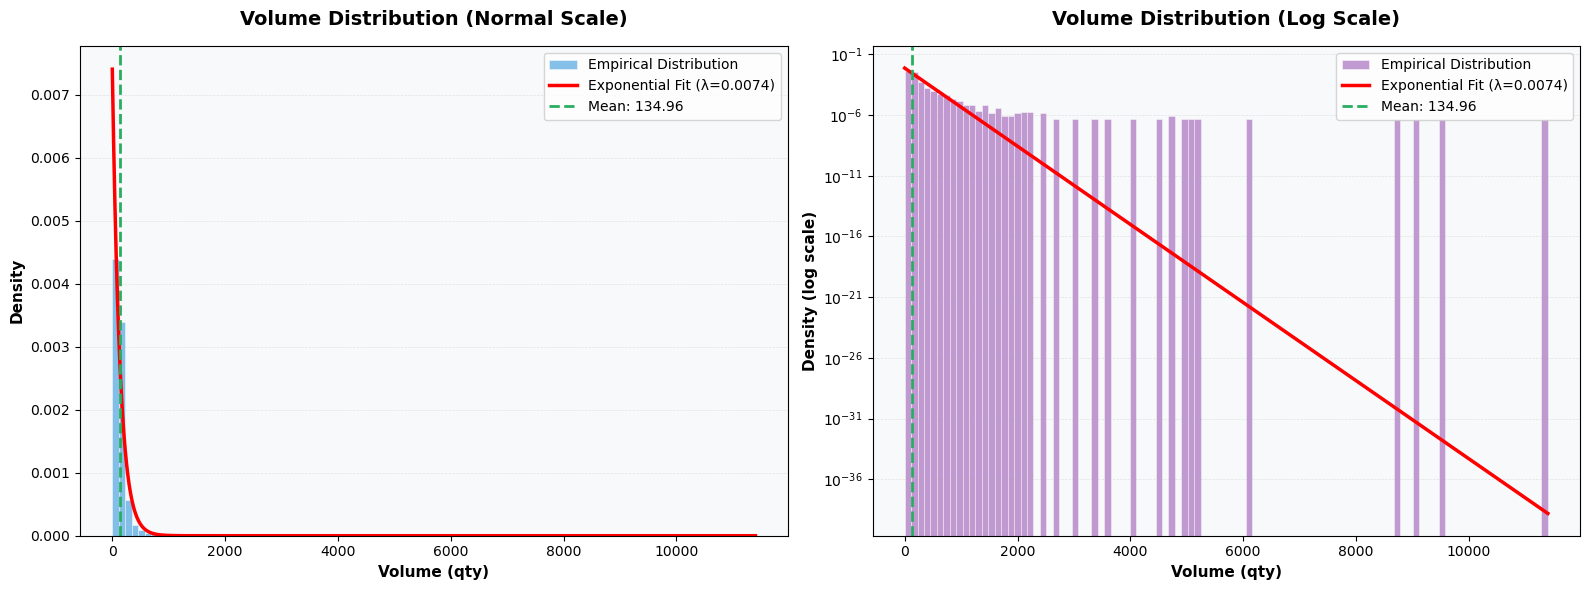

In [ ]:
def exponential_func(x, lamb, scale):
    return scale * lamb * np.exp(-lamb * x)

volumes = df0['qty'].dropna()
volumes_pos = volumes[volumes > 0] 

lamb_mle = 1 / volumes_pos.mean()  
print(f"Lambda (MLE): {lamb_mle:.6f}")
print(f"Mean volume: {volumes_pos.mean():.2f}")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

n, bins, patches = axes[0].hist(volumes_pos, bins=100, density=True, 
                                 alpha=0.6, color='#3498DB', 
                                 edgecolor='white', linewidth=0.5,
                                 label='Empirical Distribution')

x_range = np.linspace(0, volumes_pos.max(), 500)
exponential_fit = lamb_mle * np.exp(-lamb_mle * x_range)
axes[0].plot(x_range, exponential_fit, 'r-', linewidth=2.5, 
             label=f'Exponential Fit (λ={lamb_mle:.4f})')

axes[0].axvline(volumes_pos.mean(), color='#27AE60', linestyle='--', 
                linewidth=2, label=f'Mean: {volumes_pos.mean():.2f}')

axes[0].set_title('Volume Distribution (Normal Scale)', 
                  fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel('Volume (qty)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Density', fontsize=11, fontweight='bold')
axes[0].grid(True, alpha=0.3, linestyle='--', linewidth=0.5, axis='y')
axes[0].set_facecolor('#F8F9FA')
axes[0].legend(fontsize=10)

axes[1].hist(volumes_pos, bins=100, density=True, 
             alpha=0.6, color='#9B59B6', 
             edgecolor='white', linewidth=0.5,
             label='Empirical Distribution')
axes[1].set_yscale('log')

axes[1].plot(x_range, exponential_fit, 'r-', linewidth=2.5, 
             label=f'Exponential Fit (λ={lamb_mle:.4f})')

axes[1].axvline(volumes_pos.mean(), color='#27AE60', linestyle='--', 
                linewidth=2, label=f'Mean: {volumes_pos.mean():.2f}')

axes[1].set_title('Volume Distribution (Log Scale)', 
                  fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Volume (qty)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Density (log scale)', fontsize=11, fontweight='bold')
axes[1].grid(True, alpha=0.3, linestyle='--', linewidth=0.5, axis='y')
axes[1].set_facecolor('#F8F9FA')
axes[1].legend(fontsize=10)

plt.tight_layout()
plt.show()

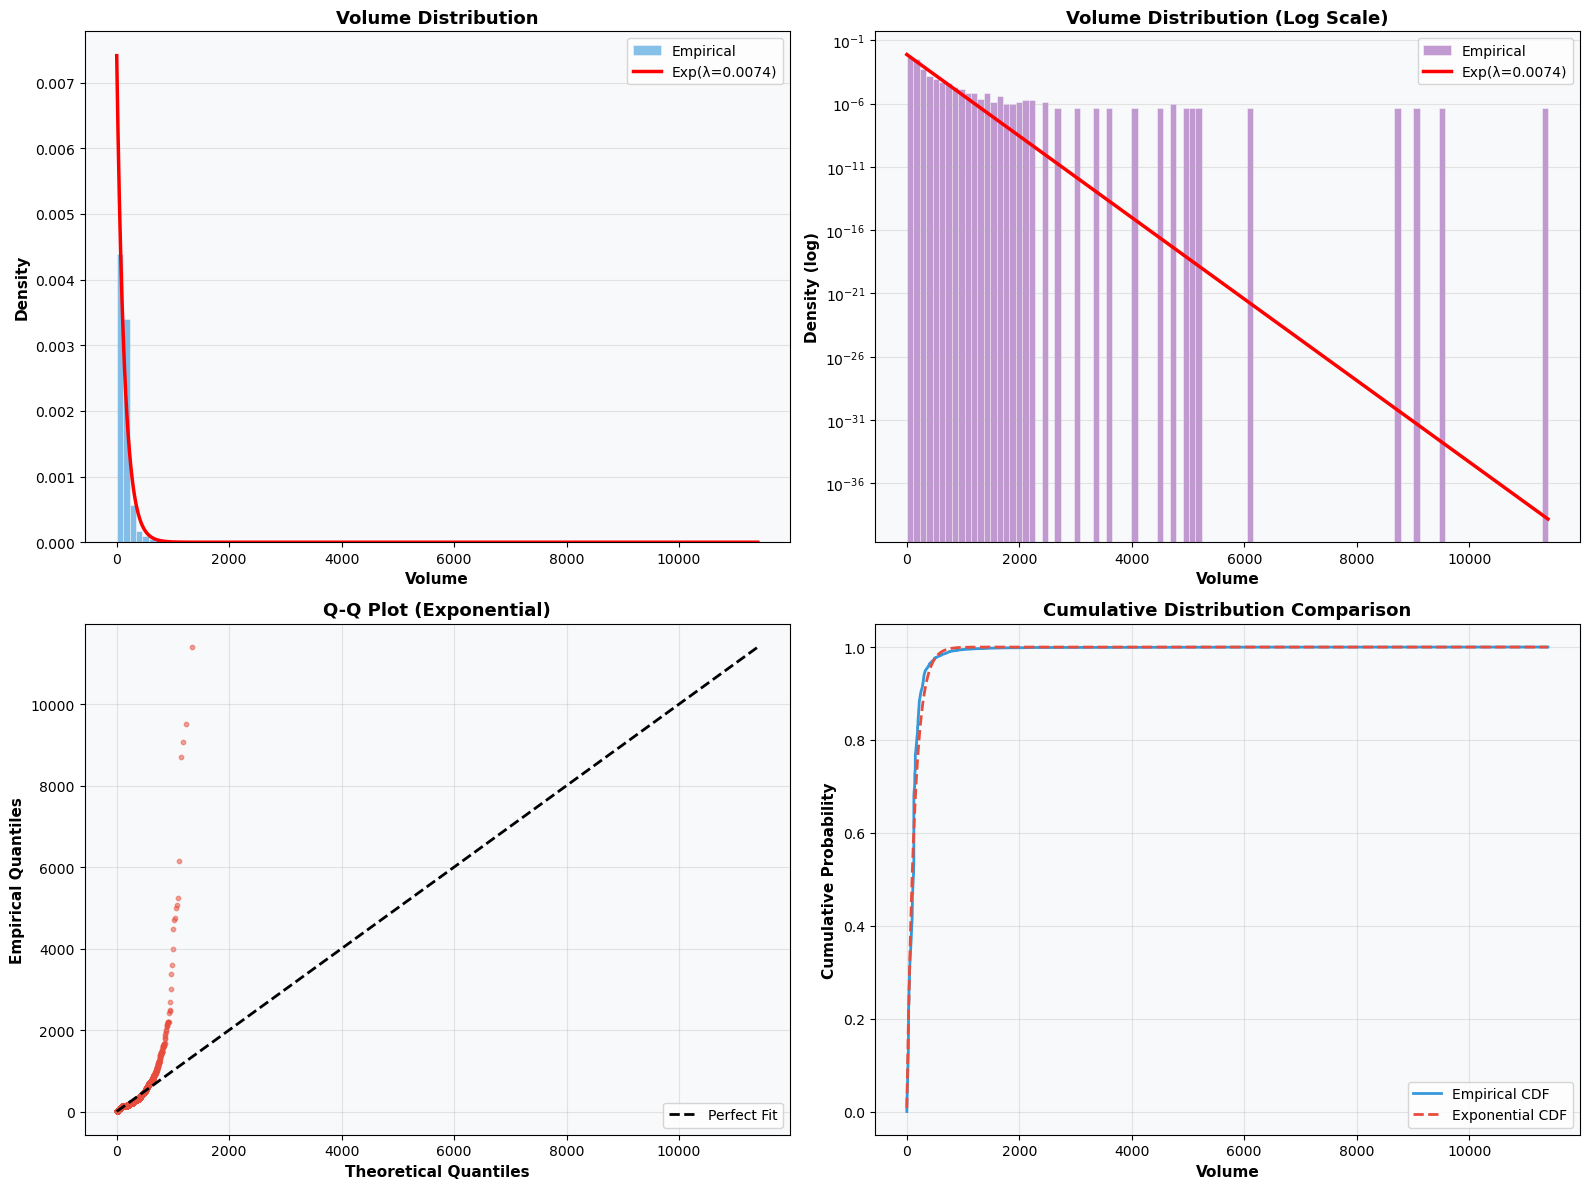


=== Goodness of Fit Statistics ===
Lambda (rate parameter): 0.007410
Mean (1/λ): 134.96
Empirical mean: 134.96

Kolmogorov-Smirnov Test:
  KS Statistic: 0.092752
  P-value: 0.000000
  → Reject exponential distribution (poor fit)


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].hist(volumes_pos, bins=100, density=True, 
                alpha=0.6, color='#3498DB', edgecolor='white', linewidth=0.5,
                label='Empirical')
x_range = np.linspace(0, volumes_pos.max(), 500)
axes[0, 0].plot(x_range, lamb_mle * np.exp(-lamb_mle * x_range), 
                'r-', linewidth=2.5, label=f'Exp(λ={lamb_mle:.4f})')
axes[0, 0].set_title('Volume Distribution', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Volume', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Density', fontsize=11, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].set_facecolor('#F8F9FA')

axes[0, 1].hist(volumes_pos, bins=100, density=True, 
                alpha=0.6, color='#9B59B6', edgecolor='white', linewidth=0.5,
                label='Empirical')
axes[0, 1].plot(x_range, lamb_mle * np.exp(-lamb_mle * x_range), 
                'r-', linewidth=2.5, label=f'Exp(λ={lamb_mle:.4f})')
axes[0, 1].set_yscale('log')
axes[0, 1].set_title('Volume Distribution (Log Scale)', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Volume', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Density (log)', fontsize=11, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].set_facecolor('#F8F9FA')

sorted_volumes = np.sort(volumes_pos)
n_points = len(sorted_volumes)
theoretical_quantiles = -np.log(1 - np.arange(1, n_points + 1) / (n_points + 1)) / lamb_mle

axes[1, 0].scatter(theoretical_quantiles, sorted_volumes, alpha=0.5, s=10, color='#E74C3C')

max_val = max(theoretical_quantiles.max(), sorted_volumes.max())
axes[1, 0].plot([0, max_val], [0, max_val], 'k--', linewidth=2, label='Perfect Fit')
axes[1, 0].set_title('Q-Q Plot (Exponential)', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Theoretical Quantiles', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Empirical Quantiles', fontsize=11, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_facecolor('#F8F9FA')

empirical_cdf = np.arange(1, n_points + 1) / n_points
theoretical_cdf = 1 - np.exp(-lamb_mle * sorted_volumes)

axes[1, 1].plot(sorted_volumes, empirical_cdf, linewidth=2, 
                color='#3498DB', label='Empirical CDF')
axes[1, 1].plot(sorted_volumes, theoretical_cdf, linewidth=2, 
                color='#E74C3C', linestyle='--', label='Exponential CDF')
axes[1, 1].set_title('Cumulative Distribution Comparison', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Volume', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Cumulative Probability', fontsize=11, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_facecolor('#F8F9FA')

plt.tight_layout()
plt.show()

ks_statistic, ks_pvalue = stats.kstest(volumes_pos, 
                                        lambda x: stats.expon.cdf(x, scale=1/lamb_mle))

print("\n=== Goodness of Fit Statistics ===")
print(f"Lambda (rate parameter): {lamb_mle:.6f}")
print(f"Mean (1/λ): {1/lamb_mle:.2f}")
print(f"Empirical mean: {volumes_pos.mean():.2f}")
print(f"\nKolmogorov-Smirnov Test:")
print(f"  KS Statistic: {ks_statistic:.6f}")
print(f"  P-value: {ks_pvalue:.6f}")
if ks_pvalue > 0.05:
    print("  → Cannot reject exponential distribution (good fit)")
else:
    print("  → Reject exponential distribution (poor fit)")

## 1.4 Volatility and traded volume

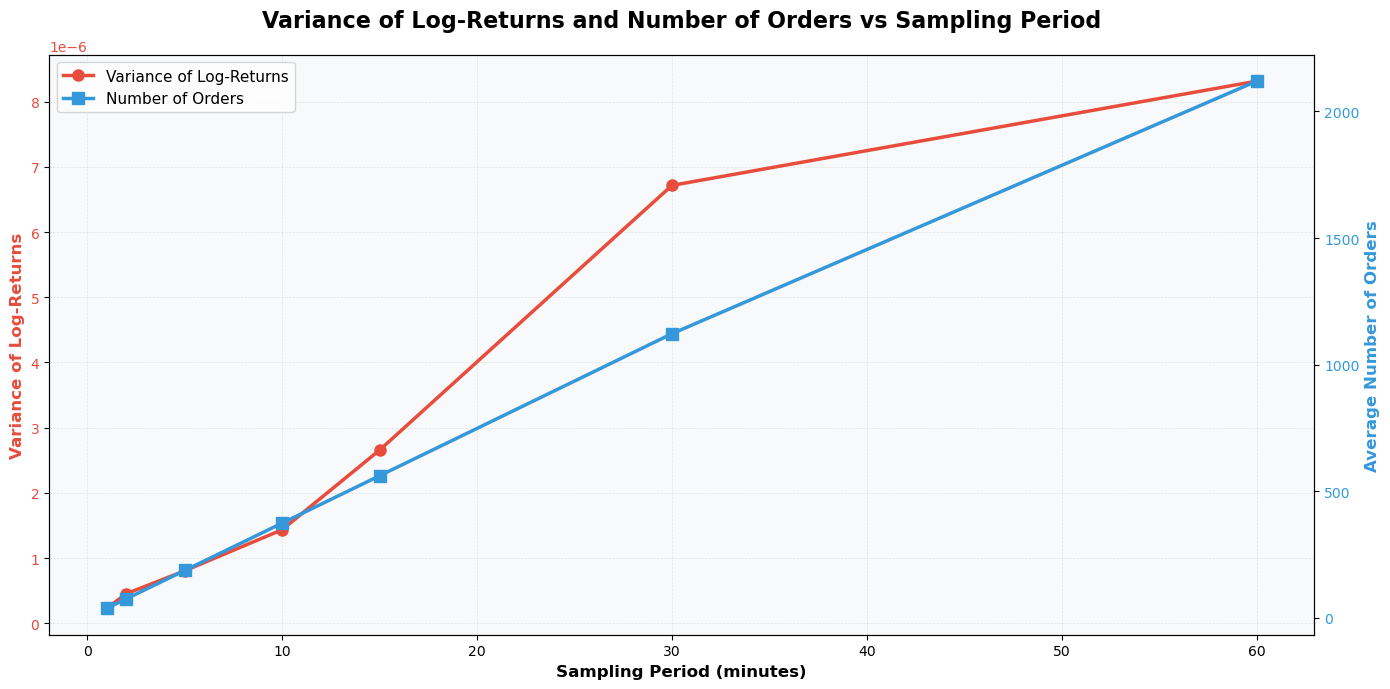

=== Variance and Number of Orders by Sampling Period ===
  1 min: Variance = 0.00000023, Avg # Orders = 37.48
  2 min: Variance = 0.00000045, Avg # Orders = 74.81
  5 min: Variance = 0.00000081, Avg # Orders = 187.02
 10 min: Variance = 0.00000144, Avg # Orders = 374.04
 15 min: Variance = 0.00000266, Avg # Orders = 561.06
 30 min: Variance = 0.00000672, Avg # Orders = 1122.12
 60 min: Variance = 0.00000831, Avg # Orders = 2119.56


In [ ]:
df0['log_price'] = np.log(df0['price'])
df0['log_return'] = df0['log_price'].diff()

sampling_periods = [1, 2, 5, 10, 15, 30, 60]  
variances = []
num_orders = []

for period in sampling_periods:
    resampled = df0.resample(f'{period}min').agg({
        'log_price': 'last',
        'qty': 'count'  
    }).dropna()
    
    resampled_log_returns = resampled['log_price'].diff().dropna()
    var = resampled_log_returns.var()
    variances.append(var)

    avg_num_orders = resampled['qty'].mean()
    num_orders.append(avg_num_orders)

fig, ax1 = plt.subplots(figsize=(14, 7))

color1 = '#E74C3C'
ax1.set_xlabel('Sampling Period (minutes)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Variance of Log-Returns', fontsize=12, fontweight='bold', color=color1)
line1 = ax1.plot(sampling_periods, variances, 'o-', color=color1, 
                 linewidth=2.5, markersize=8, label='Variance of Log-Returns')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
ax1.set_facecolor('#F8F9FA')

ax2 = ax1.twinx()
color2 = '#3498DB'
ax2.set_ylabel('Average Number of Orders', fontsize=12, fontweight='bold', color=color2)
line2 = ax2.plot(sampling_periods, num_orders, 's-', color=color2, 
                 linewidth=2.5, markersize=8, label='Number of Orders')
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('Variance of Log-Returns and Number of Orders vs Sampling Period', 
          fontsize=16, fontweight='bold', pad=20)

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=11)

plt.tight_layout()
plt.show()

print("=== Variance and Number of Orders by Sampling Period ===")
for period, var, n_ord in zip(sampling_periods, variances, num_orders):
    print(f"{period:3d} min: Variance = {var:.8f}, Avg # Orders = {n_ord:.2f}")

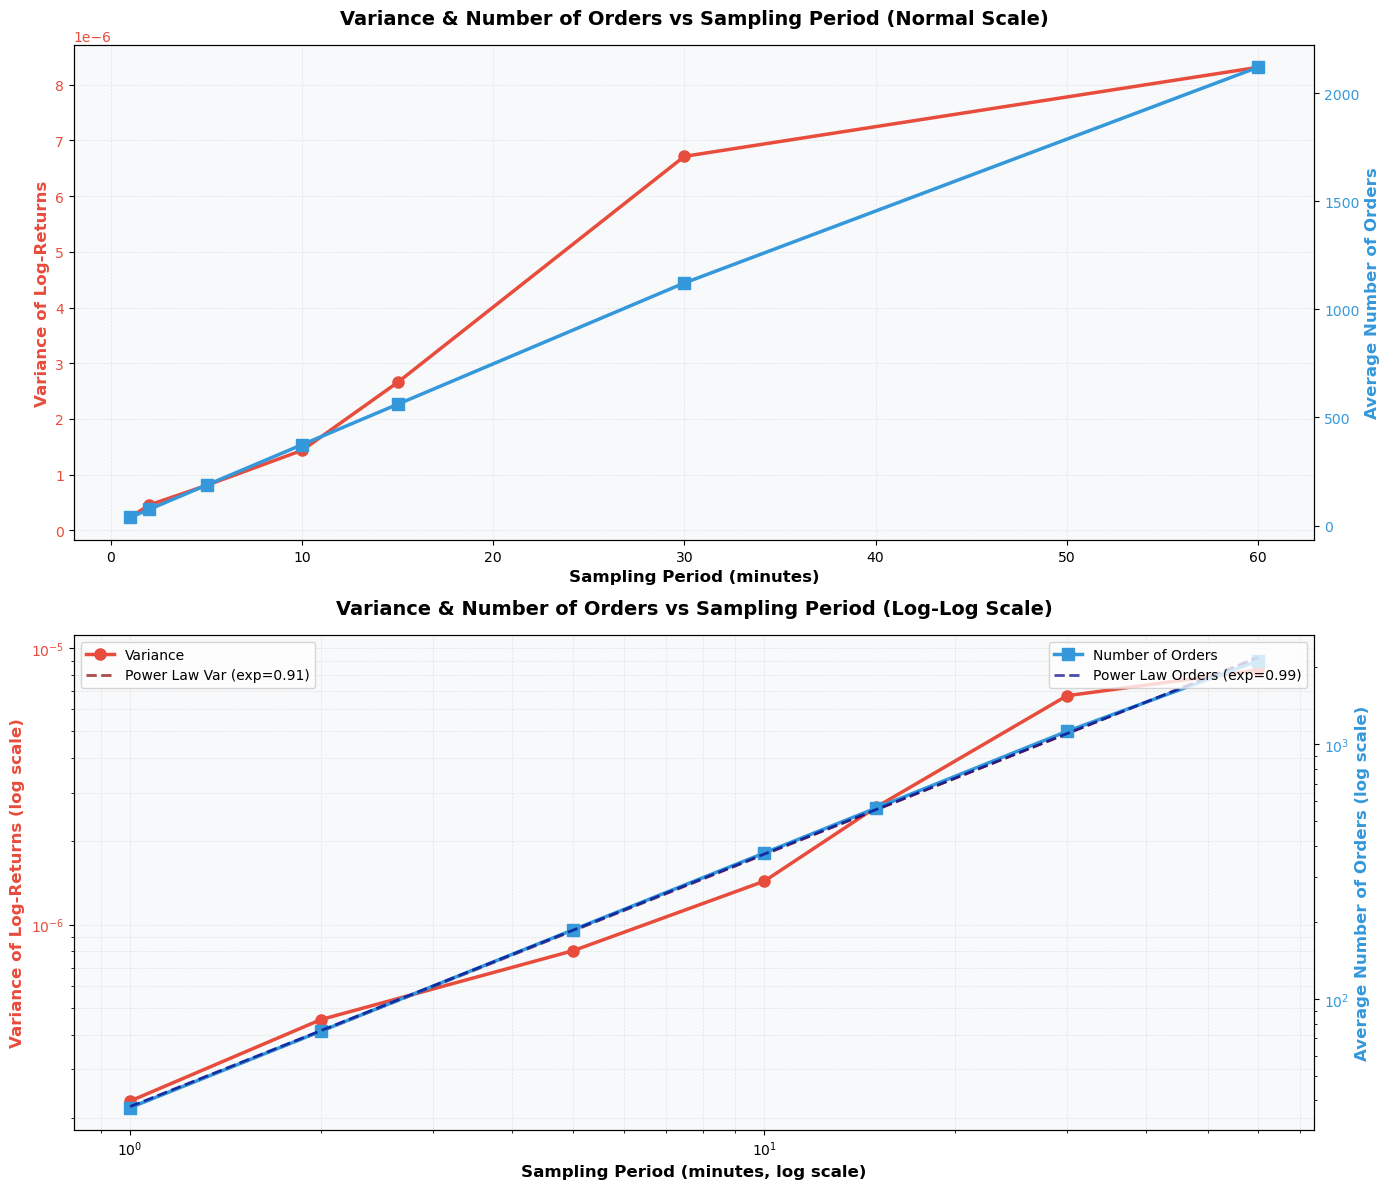


=== Power Law Analysis ===
Variance ~ Period^0.915
Number of Orders ~ Period^0.991

Variance Interpretation:
  → Close to linear scaling (Brownian motion behavior)

Orders Interpretation:
  → Linear growth: uniform order arrival rate

=== Variance and Number of Orders by Sampling Period ===
  1 min: Variance = 0.00000023, Avg # Orders = 37.48
  2 min: Variance = 0.00000045, Avg # Orders = 74.81
  5 min: Variance = 0.00000081, Avg # Orders = 187.02
 10 min: Variance = 0.00000144, Avg # Orders = 374.04
 15 min: Variance = 0.00000266, Avg # Orders = 561.06
 30 min: Variance = 0.00000672, Avg # Orders = 1122.12
 60 min: Variance = 0.00000831, Avg # Orders = 2119.56


In [ ]:
df0['log_price'] = np.log(df0['price'])
df0['log_return'] = df0['log_price'].diff()

sampling_periods = [1, 2, 5, 10, 15, 30, 60]  
variances = []
num_orders = []

for period in sampling_periods:
    resampled = df0.resample(f'{period}min').agg({
        'log_price': 'last',
        'qty': 'count'  
    }).dropna()
    
    resampled_log_returns = resampled['log_price'].diff().dropna()
    var = resampled_log_returns.var()
    variances.append(var)

    avg_num_orders = resampled['qty'].mean()
    num_orders.append(avg_num_orders)

fig, axes = plt.subplots(2, 1, figsize=(14, 12))

ax1 = axes[0]
color1 = '#E74C3C'
ax1.set_xlabel('Sampling Period (minutes)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Variance of Log-Returns', fontsize=12, fontweight='bold', color=color1)
ax1.plot(sampling_periods, variances, 'o-', color=color1, 
         linewidth=2.5, markersize=8, label='Variance')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
ax1.set_facecolor('#F8F9FA')

ax2 = ax1.twinx()
color2 = '#3498DB'
ax2.set_ylabel('Average Number of Orders', fontsize=12, fontweight='bold', color=color2)
ax2.plot(sampling_periods, num_orders, 's-', color=color2, 
         linewidth=2.5, markersize=8, label='Number of Orders')
ax2.tick_params(axis='y', labelcolor=color2)

ax1.set_title('Variance & Number of Orders vs Sampling Period (Normal Scale)', 
              fontsize=14, fontweight='bold', pad=15)

ax3 = axes[1]
color1 = '#E74C3C'
ax3.set_xlabel('Sampling Period (minutes, log scale)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Variance of Log-Returns (log scale)', fontsize=12, fontweight='bold', color=color1)
ax3.loglog(sampling_periods, variances, 'o-', color=color1, 
           linewidth=2.5, markersize=8, label='Variance')
ax3.tick_params(axis='y', labelcolor=color1)
ax3.grid(True, alpha=0.3, linestyle='--', linewidth=0.5, which='both')
ax3.set_facecolor('#F8F9FA')

log_periods = np.log(sampling_periods)
log_variances = np.log(variances)
slope_var, intercept_var = np.polyfit(log_periods, log_variances, 1)
fit_variances = np.exp(intercept_var) * np.array(sampling_periods)**slope_var
ax3.plot(sampling_periods, fit_variances, '--', color='darkred', 
         linewidth=2, alpha=0.7, label=f'Power Law Var (exp={slope_var:.2f})')

ax4 = ax3.twinx()
color2 = '#3498DB'
ax4.set_ylabel('Average Number of Orders (log scale)', fontsize=12, fontweight='bold', color=color2)
ax4.loglog(sampling_periods, num_orders, 's-', color=color2, 
           linewidth=2.5, markersize=8, label='Number of Orders')
ax4.tick_params(axis='y', labelcolor=color2)

log_orders = np.log(num_orders)
slope_ord, intercept_ord = np.polyfit(log_periods, log_orders, 1)
fit_orders = np.exp(intercept_ord) * np.array(sampling_periods)**slope_ord
ax4.plot(sampling_periods, fit_orders, '--', color='darkblue', 
         linewidth=2, alpha=0.7, label=f'Power Law Orders (exp={slope_ord:.2f})')

ax3.set_title('Variance & Number of Orders vs Sampling Period (Log-Log Scale)', 
              fontsize=14, fontweight='bold', pad=15)

lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax4.get_legend_handles_labels()
ax3.legend(lines1, labels1, loc='upper left', fontsize=10)
ax4.legend(lines2, labels2, loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\n=== Power Law Analysis ===")
print(f"Variance ~ Period^{slope_var:.3f}")
print(f"Number of Orders ~ Period^{slope_ord:.3f}")
print(f"\nVariance Interpretation:")
if abs(slope_var - 1.0) < 0.1:
    print("  → Close to linear scaling (Brownian motion behavior)")
elif slope_var > 1:
    print("  → Super-diffusive behavior")
else:
    print("  → Sub-diffusive behavior")
print(f"\nOrders Interpretation:")
if abs(slope_ord - 1.0) < 0.1:
    print("  → Linear growth: uniform order arrival rate")
elif slope_ord > 1:
    print("  → Super-linear: order clustering at longer timescales")
else:
    print("  → Sub-linear: order dispersion")

print("\n=== Variance and Number of Orders by Sampling Period ===")
for period, var, n_ord in zip(sampling_periods, variances, num_orders):
    print(f"{period:3d} min: Variance = {var:.8f}, Avg # Orders = {n_ord:.2f}")

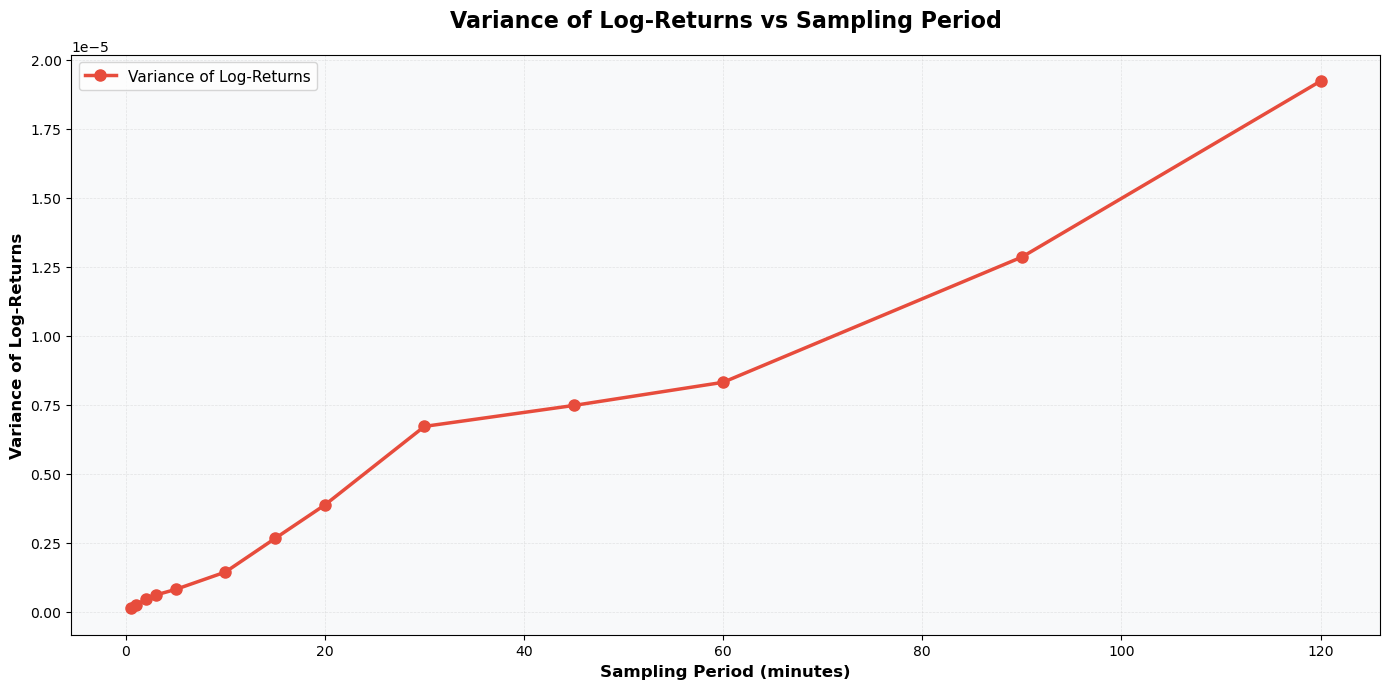

=== Variance by Sampling Period ===
   0.5 min: Variance = 0.00000012
   1.0 min: Variance = 0.00000023
   2.0 min: Variance = 0.00000045
   3.0 min: Variance = 0.00000060
   5.0 min: Variance = 0.00000081
  10.0 min: Variance = 0.00000144
  15.0 min: Variance = 0.00000266
  20.0 min: Variance = 0.00000387
  30.0 min: Variance = 0.00000672
  45.0 min: Variance = 0.00000747
  60.0 min: Variance = 0.00000831
  90.0 min: Variance = 0.00001285
 120.0 min: Variance = 0.00001923


In [ ]:
if 'log_price' not in df0.columns:
    df0['log_price'] = np.log(df0['price'])

sampling_periods = [0.5, 1, 2, 3, 5, 10, 15, 20, 30, 45, 60, 90, 120]
variances = []

for period in sampling_periods:
    if period < 1:
        freq_str = f'{int(period*60)}s'
    else:
        freq_str = f'{int(period)}min'
    
    resampled = df0['log_price'].resample(freq_str).last().dropna()
    
    if len(resampled) > 2:  
        log_returns = resampled.diff().dropna()
        var = log_returns.var()
        variances.append(var)
    else:
        variances.append(np.nan)

valid_indices = ~np.isnan(variances)
sampling_periods_clean = np.array(sampling_periods)[valid_indices]
variances_clean = np.array(variances)[valid_indices]

fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(sampling_periods_clean, variances_clean, 'o-', color='#E74C3C', 
        linewidth=2.5, markersize=8, label='Variance of Log-Returns')

ax.set_title('Variance of Log-Returns vs Sampling Period', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Sampling Period (minutes)', fontsize=12, fontweight='bold')
ax.set_ylabel('Variance of Log-Returns', fontsize=12, fontweight='bold')

ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_facecolor('#F8F9FA')
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

print("=== Variance by Sampling Period ===")
for period, var in zip(sampling_periods_clean, variances_clean):
    print(f"{period:6.1f} min: Variance = {var:.8f}")

## 1.5 High Frequency Data


Sampling: 1 minutes
Event Time:    μ = 0.00002313, σ = 0.00048007
               Skewness = -0.0869
               Kurtosis = 2.1437
Calendar Time: μ = 0.00002309, σ = 0.00047913
               N_obs = 508

Sampling: 5 minutes
Event Time:    μ = 0.00012535, σ = 0.00089757
               Skewness = 0.5247
               Kurtosis = 2.1781
Calendar Time: μ = 0.00012535, σ = 0.00089312
               N_obs = 101

Sampling: 15 minutes
Event Time:    μ = 0.00031204, σ = 0.00162982
               Skewness = 0.0958
               Kurtosis = 1.2910
Calendar Time: μ = 0.00031204, σ = 0.00160494
               N_obs = 33

Sampling: 30 minutes
Event Time:    μ = 0.00054152, σ = 0.00259134
               Skewness = 0.8605
               Kurtosis = 2.4087
Calendar Time: μ = 0.00054152, σ = 0.00250906
               N_obs = 16

Sampling: 60 minutes
Event Time:    μ = 0.00015736, σ = 0.00288330
               Skewness = -0.9873
               Kurtosis = 0.7670
Calendar Time: μ = 0.00015736, σ = 0.002

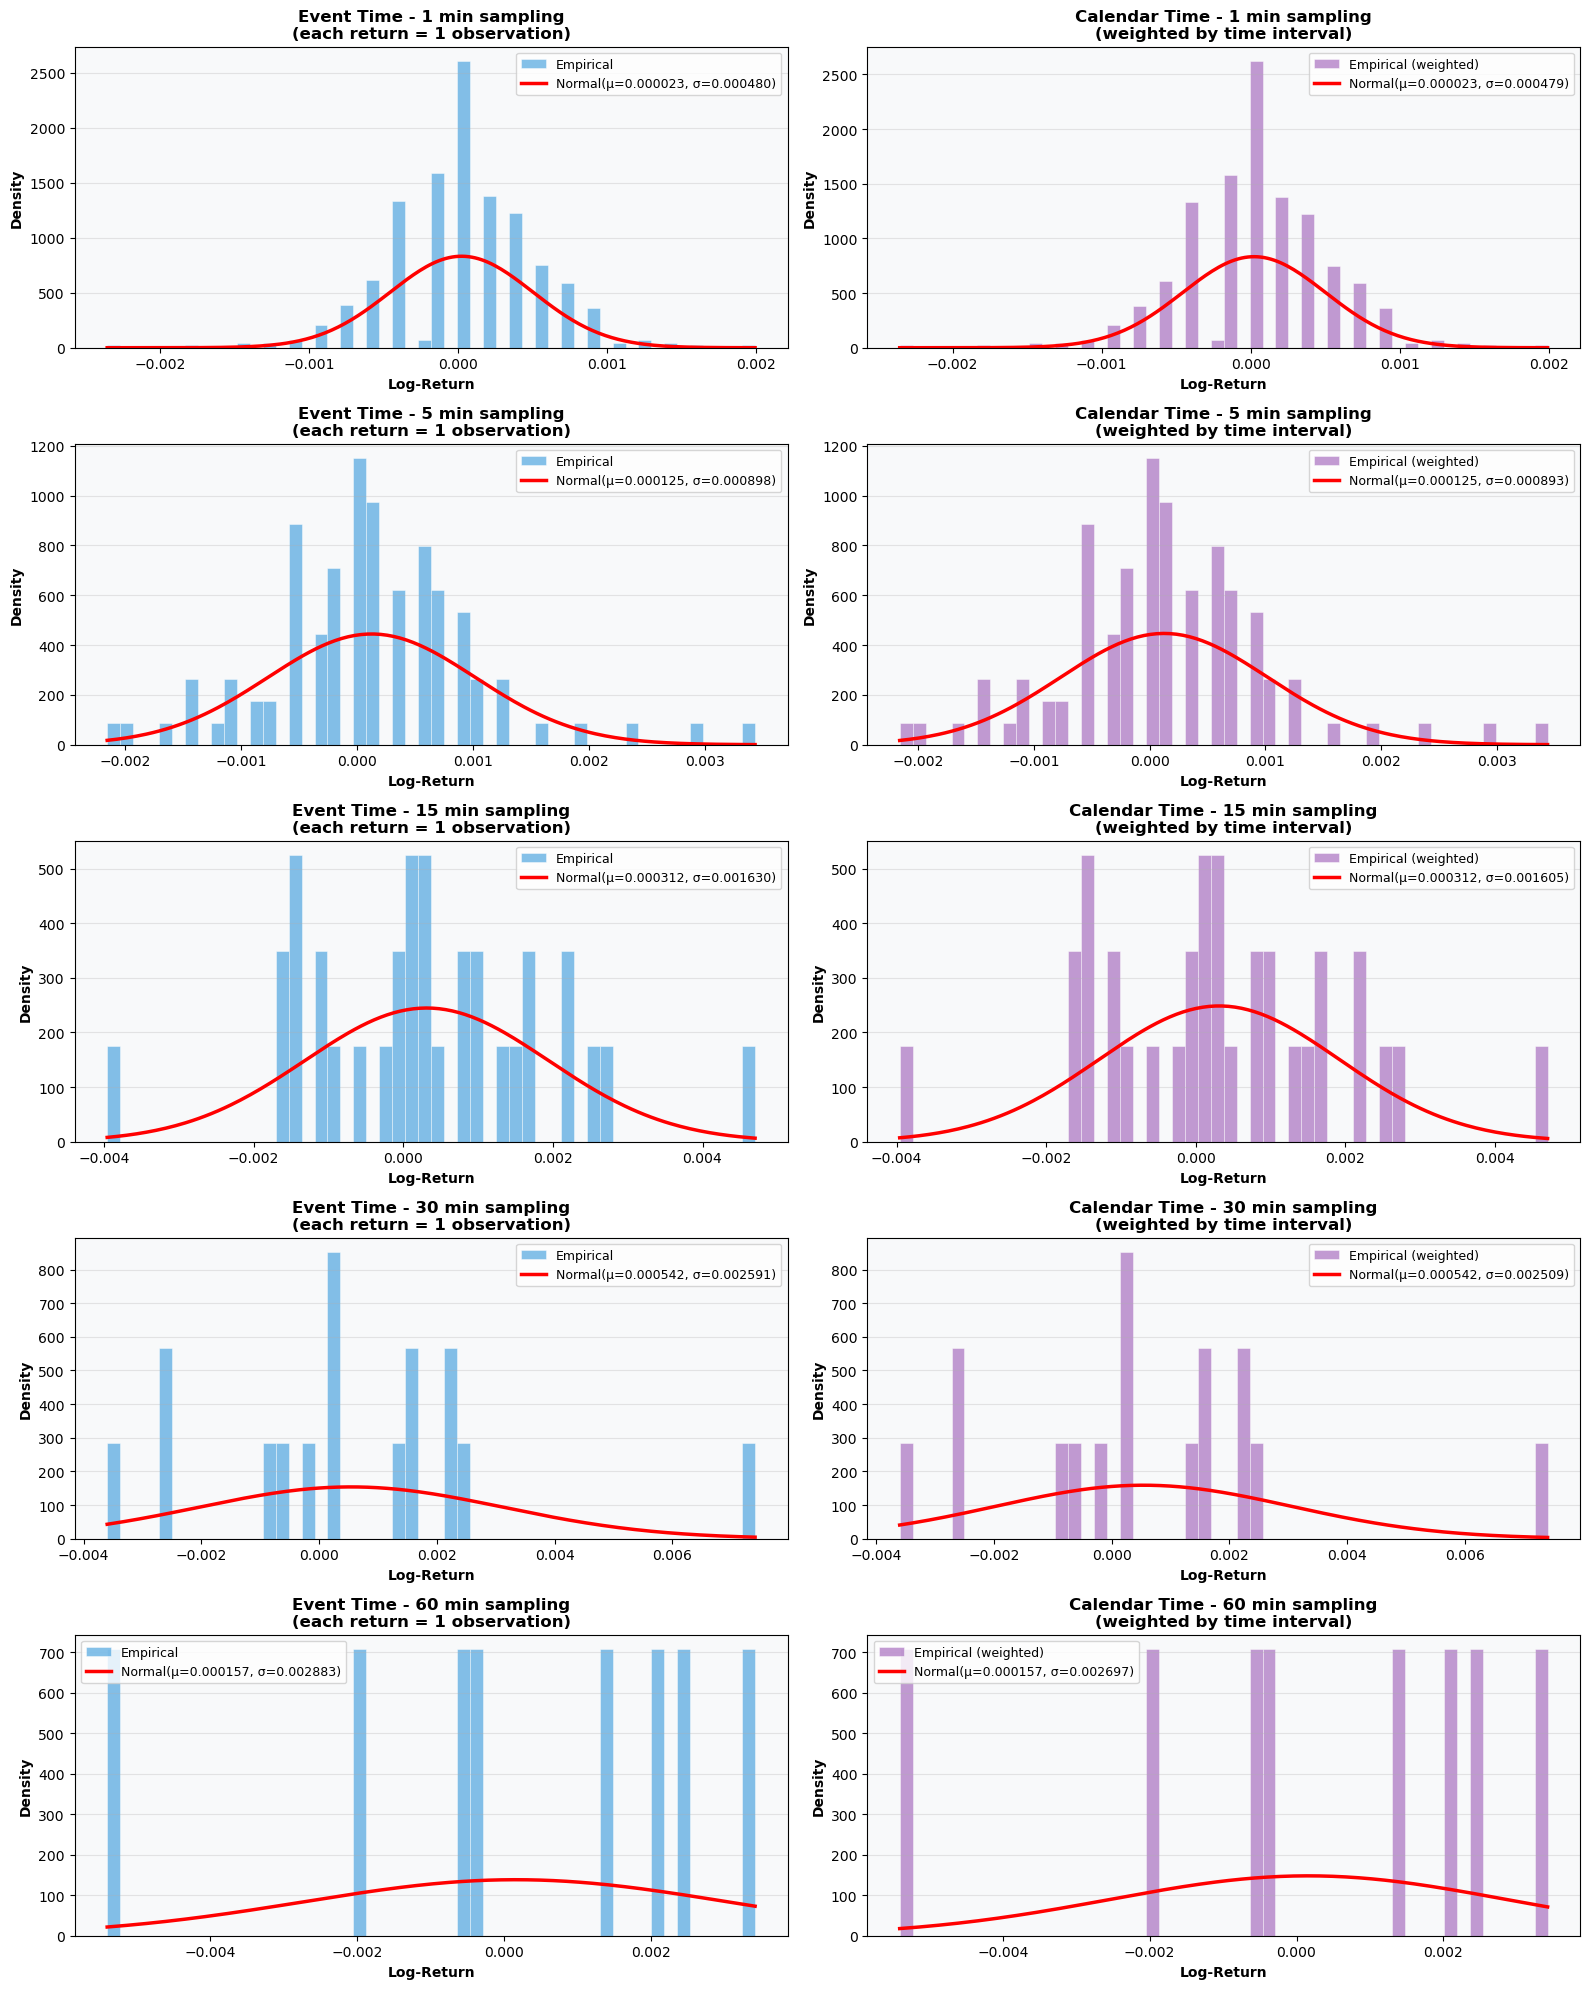

In [ ]:
sampling_freqs = [1, 5, 15, 30, 60]  

fig, axes = plt.subplots(len(sampling_freqs), 2, figsize=(16, 4*len(sampling_freqs)))

for idx, freq in enumerate(sampling_freqs):
    freq_str = f'{freq}min'
    
    resampled = df0.resample(freq_str).agg({
        'log_price': 'last'
    }).dropna()
    
    log_returns = resampled['log_price'].diff().dropna()

    ax_event = axes[idx, 0]

    n, bins, patches = ax_event.hist(log_returns, bins=50, density=True, 
                                      alpha=0.6, color='#3498DB', 
                                      edgecolor='white', linewidth=0.5,
                                      label='Empirical')
    
    mu_event, sigma_event = log_returns.mean(), log_returns.std()
    x_range = np.linspace(log_returns.min(), log_returns.max(), 200)
    normal_fit = stats.norm.pdf(x_range, mu_event, sigma_event)
    ax_event.plot(x_range, normal_fit, 'r-', linewidth=2.5, 
                  label=f'Normal(μ={mu_event:.6f}, σ={sigma_event:.6f})')
    
    ax_event.set_title(f'Event Time - {freq} min sampling\n(each return = 1 observation)', 
                       fontsize=12, fontweight='bold')
    ax_event.set_xlabel('Log-Return', fontsize=10, fontweight='bold')
    ax_event.set_ylabel('Density', fontsize=10, fontweight='bold')
    ax_event.legend(fontsize=9)
    ax_event.grid(True, alpha=0.3, axis='y')
    ax_event.set_facecolor('#F8F9FA')
    
    ax_calendar = axes[idx, 1]
    
    time_deltas = resampled.index.to_series().diff().dt.total_seconds() / 60  
    time_deltas = time_deltas[1:]  
    
    weights = time_deltas / time_deltas.sum()
    
    ax_calendar.hist(log_returns, bins=50, density=True, weights=weights,
                     alpha=0.6, color='#9B59B6', 
                     edgecolor='white', linewidth=0.5,
                     label='Empirical (weighted)')
    
    mu_calendar = np.average(log_returns, weights=weights)
    sigma_calendar = np.sqrt(np.average((log_returns - mu_calendar)**2, weights=weights))
    normal_fit_weighted = stats.norm.pdf(x_range, mu_calendar, sigma_calendar)
    ax_calendar.plot(x_range, normal_fit_weighted, 'r-', linewidth=2.5,
                     label=f'Normal(μ={mu_calendar:.6f}, σ={sigma_calendar:.6f})')
    
    ax_calendar.set_title(f'Calendar Time - {freq} min sampling\n(weighted by time interval)', 
                          fontsize=12, fontweight='bold')
    ax_calendar.set_xlabel('Log-Return', fontsize=10, fontweight='bold')
    ax_calendar.set_ylabel('Density', fontsize=10, fontweight='bold')
    ax_calendar.legend(fontsize=9)
    ax_calendar.grid(True, alpha=0.3, axis='y')
    ax_calendar.set_facecolor('#F8F9FA')
    
    print(f"\n{'='*60}")
    print(f"Sampling: {freq} minutes")
    print(f"{'='*60}")
    print(f"Event Time:    μ = {mu_event:.8f}, σ = {sigma_event:.8f}")
    print(f"               Skewness = {log_returns.skew():.4f}")
    print(f"               Kurtosis = {log_returns.kurtosis():.4f}")
    print(f"Calendar Time: μ = {mu_calendar:.8f}, σ = {sigma_calendar:.8f}")
    print(f"               N_obs = {len(log_returns)}")

plt.tight_layout()
plt.show()

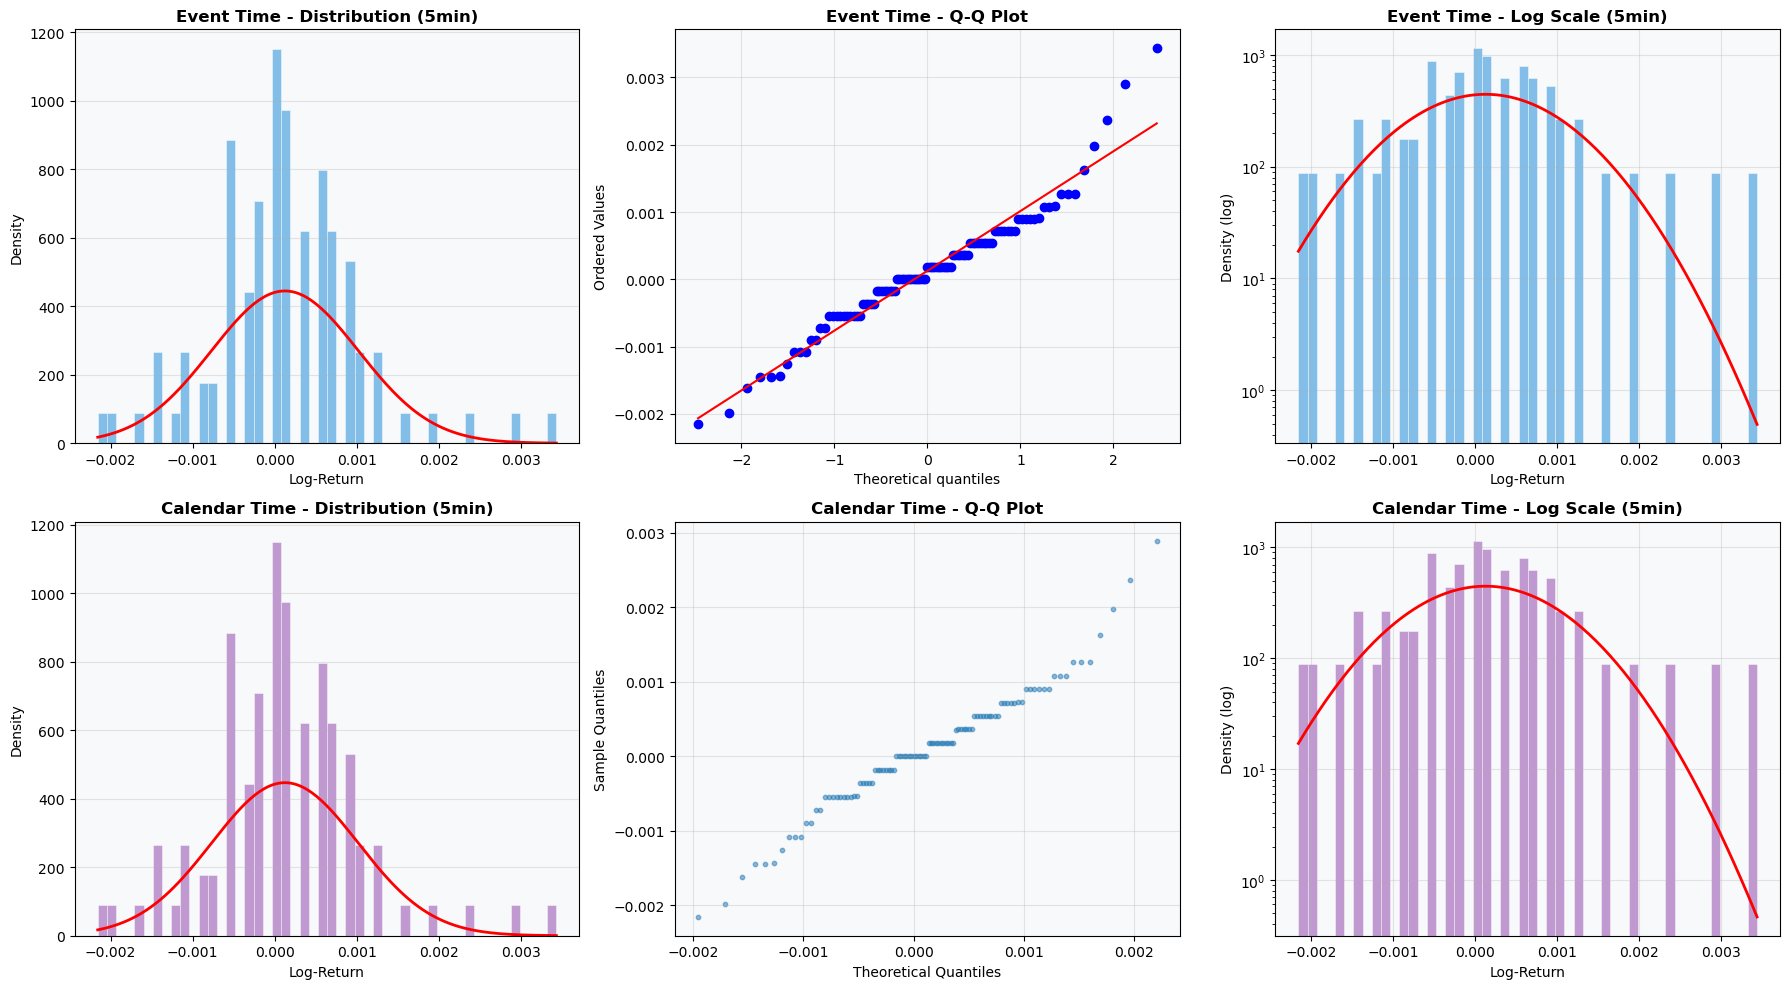

In [ ]:
freq = 5  
freq_str = f'{freq}min'

resampled = df0.resample(freq_str).agg({'log_price': 'last'}).dropna()
log_returns = resampled['log_price'].diff().dropna()
time_deltas = resampled.index.to_series().diff().dt.total_seconds()[1:] / 60
weights = time_deltas / time_deltas.sum()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

axes[0, 0].hist(log_returns, bins=50, density=True, alpha=0.6, 
                color='#3498DB', edgecolor='white', linewidth=0.5)
mu_e, sigma_e = log_returns.mean(), log_returns.std()
x = np.linspace(log_returns.min(), log_returns.max(), 200)
axes[0, 0].plot(x, stats.norm.pdf(x, mu_e, sigma_e), 'r-', linewidth=2)
axes[0, 0].set_title(f'Event Time - Distribution ({freq}min)', fontweight='bold')
axes[0, 0].set_xlabel('Log-Return')
axes[0, 0].set_ylabel('Density')
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].set_facecolor('#F8F9FA')

stats.probplot(log_returns, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Event Time - Q-Q Plot', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_facecolor('#F8F9FA')

axes[0, 2].hist(log_returns, bins=50, density=True, alpha=0.6,
                color='#3498DB', edgecolor='white', linewidth=0.5)
axes[0, 2].plot(x, stats.norm.pdf(x, mu_e, sigma_e), 'r-', linewidth=2)
axes[0, 2].set_yscale('log')
axes[0, 2].set_title(f'Event Time - Log Scale ({freq}min)', fontweight='bold')
axes[0, 2].set_xlabel('Log-Return')
axes[0, 2].set_ylabel('Density (log)')
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].set_facecolor('#F8F9FA')

axes[1, 0].hist(log_returns, bins=50, density=True, weights=weights,
                alpha=0.6, color='#9B59B6', edgecolor='white', linewidth=0.5)
mu_c = np.average(log_returns, weights=weights)
sigma_c = np.sqrt(np.average((log_returns - mu_c)**2, weights=weights))
axes[1, 0].plot(x, stats.norm.pdf(x, mu_c, sigma_c), 'r-', linewidth=2)
axes[1, 0].set_title(f'Calendar Time - Distribution ({freq}min)', fontweight='bold')
axes[1, 0].set_xlabel('Log-Return')
axes[1, 0].set_ylabel('Density')
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].set_facecolor('#F8F9FA')

sorted_returns = np.sort(log_returns)
sorted_weights = weights.values[np.argsort(log_returns)]
cumulative_weights = np.cumsum(sorted_weights)
theoretical_quantiles = stats.norm.ppf(cumulative_weights, mu_c, sigma_c)
axes[1, 1].scatter(theoretical_quantiles, sorted_returns, alpha=0.5, s=10)
axes[1, 1].plot([theoretical_quantiles.min(), theoretical_quantiles.max()],
                [theoretical_quantiles.min(), theoretical_quantiles.max()], 
                'r--', linewidth=2)
axes[1, 1].set_title('Calendar Time - Q-Q Plot', fontweight='bold')
axes[1, 1].set_xlabel('Theoretical Quantiles')
axes[1, 1].set_ylabel('Sample Quantiles')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_facecolor('#F8F9FA')

axes[1, 2].hist(log_returns, bins=50, density=True, weights=weights,
                alpha=0.6, color='#9B59B6', edgecolor='white', linewidth=0.5)
axes[1, 2].plot(x, stats.norm.pdf(x, mu_c, sigma_c), 'r-', linewidth=2)
axes[1, 2].set_yscale('log')
axes[1, 2].set_title(f'Calendar Time - Log Scale ({freq}min)', fontweight='bold')
axes[1, 2].set_xlabel('Log-Return')
axes[1, 2].set_ylabel('Density (log)')
axes[1, 2].grid(True, alpha=0.3)
axes[1, 2].set_facecolor('#F8F9FA')

plt.tight_layout()
plt.show()

# Question 2 : Quotes

## 2.1 Dataset

In [ ]:
df0 = open_convert_data("stock0_day0_updates.csv.gz")
df1 = open_convert_data("stock1_day0_updates.csv.gz")
df2 = open_convert_data("stock2_day0_updates.csv.gz")

In [ ]:
def lob_basic_checks(df):
    checks = {}

    checks["n_updates"] = len(df)

    checks["missing_bp"] = df["bp"].isna().mean()
    checks["missing_ap"] = df["ap"].isna().mean()
    checks["missing_bq"] = df["bq"].isna().mean()
    checks["missing_aq"] = df["aq"].isna().mean()

    checks["non_positive_bp"] = (df["bp"] <= 0).sum()
    checks["non_positive_ap"] = (df["ap"] <= 0).sum()

    # Bid should always be <= ask
    checks["crossed_books"] = (df["bp"] > df["ap"]).sum()

    return pd.Series(checks)

In [ ]:
df0

type     bp       bq     ap       aq
ts                                                             
2026-01-26 09:00:00.340497    U    NaN  19671.0    NaN  24789.0
2026-01-26 09:00:00.503532    U    NaN  19671.0    NaN  24789.0
2026-01-26 09:00:00.503539    U    NaN  19671.0    NaN  24789.0
2026-01-26 09:00:00.503565    U    NaN  19671.0    NaN  24789.0
2026-01-26 09:00:00.503735    U    NaN  19671.0    NaN  24789.0
...                         ...    ...      ...    ...      ...
2026-01-26 17:29:58.696978    U  55.63    337.0  55.65    462.0
2026-01-26 17:29:58.697298    U  55.63    557.0  55.65    462.0
2026-01-26 17:29:59.044651    U  55.63    517.0  55.65    462.0
2026-01-26 17:29:59.123752    U  55.63    522.0  55.65    462.0
2026-01-26 17:29:59.615517    U  55.63    523.0  55.65    462.0

[226217 rows x 5 columns]

In [ ]:
lob_basic_checks(df0)

n_updates          226217.000000
missing_bp              0.000393
missing_ap              0.000393
missing_bq              0.000000
missing_aq              0.000000
non_positive_bp         0.000000
non_positive_ap         0.000000
crossed_books           0.000000
dtype: float64

In [ ]:
df1

type      bp      bq      ap      aq
ts                                                             
2026-01-26 09:00:00.050343    U     NaN  2961.0     NaN  1912.0
2026-01-26 09:00:00.087730    U     NaN  2961.0     NaN  1912.0
2026-01-26 09:00:00.093528    U     NaN  2961.0     NaN  1912.0
2026-01-26 09:00:00.133887    U     NaN  2961.0     NaN  1912.0
2026-01-26 09:00:00.134330    U     NaN  2958.0     NaN  1912.0
...                         ...     ...     ...     ...     ...
2026-01-26 17:29:59.251404    U  26.715   205.0  26.725    27.0
2026-01-26 17:29:59.252771    U  26.715   205.0  26.725   188.0
2026-01-26 17:29:59.252808    U  26.710   317.0  26.725   188.0
2026-01-26 17:29:59.252846    U  26.710   267.0  26.725   188.0
2026-01-26 17:29:59.252872    U  26.710   210.0  26.725   188.0

[73947 rows x 5 columns]

In [ ]:
df2

type     bp       bq     ap      aq
ts                                                            
2026-01-26 09:00:00.048442    U    NaN  22590.0    NaN  3666.0
2026-01-26 09:00:00.071613    U    NaN  22590.0    NaN  3666.0
2026-01-26 09:00:00.071618    U    NaN  22590.0    NaN  3666.0
2026-01-26 09:00:00.071673    U    NaN  22590.0    NaN  3666.0
2026-01-26 09:00:00.071689    U    NaN  22590.0    NaN  3666.0
...                         ...    ...      ...    ...     ...
2026-01-26 17:29:55.613839    U  53.33    805.0  53.36   800.0
2026-01-26 17:29:55.613878    U  53.33    835.0  53.36   800.0
2026-01-26 17:29:56.845833    U  53.33    868.0  53.36   800.0
2026-01-26 17:29:59.040070    U  53.33    835.0  53.36   800.0
2026-01-26 17:29:59.040075    U  53.33    835.0  53.36   768.0

[212731 rows x 5 columns]

In [ ]:
df1.describe()

bp            bq            ap            aq
count  73581.000000  73947.000000  73581.000000  73947.000000
mean      26.475909    367.620999     26.489311    420.093621
std        0.178777    371.052801      0.175179    487.450106
min       26.000000      1.000000     26.030000      1.000000
25%       26.340000    196.000000     26.355000    207.000000
50%       26.460000    287.000000     26.470000    310.000000
75%       26.620000    480.000000     26.630000    540.000000
max       26.840000   7804.000000     26.850000  13731.000000

In [ ]:
df0.describe()

bp             bq             ap             aq
count  226128.000000  226217.000000  226128.000000  226217.000000
mean       55.415979     686.646393      55.429111     938.348183
std         0.151465     910.275112       0.150203    1029.520042
min        54.830000       1.000000      54.870000       1.000000
25%        55.330000     308.000000      55.340000     344.000000
50%        55.400000     573.000000      55.410000     701.000000
75%        55.530000     901.000000      55.540000    1253.000000
max        55.740000   31820.000000      55.750000   25516.000000

In [ ]:
df2.describe()

bp             bq             ap             aq
count  212559.000000  212731.000000  212559.000000  212731.000000
mean       53.540530     587.327164      53.554989     622.253771
std         0.166649     808.682521       0.165288     560.670071
min        52.860000       1.000000      52.900000       1.000000
25%        53.440000     236.000000      53.450000     239.000000
50%        53.540000     427.000000      53.550000     476.000000
75%        53.680000     785.000000      53.690000     850.000000
max        53.850000   22590.000000      53.870000    8247.000000

In [ ]:
df0.isna().sum()

type     0
bp      89
bq       0
ap      89
aq       0
dtype: int64

In [ ]:
df1.isna().sum()

type      0
bp      366
bq        0
ap      366
aq        0
dtype: int64

In [ ]:
df2.isna().sum()

type      0
bp      172
bq        0
ap      172
aq        0
dtype: int64

In [ ]:
df0 = df0.dropna()
df1 = df1.dropna()
df2 = df2.dropna()

In [ ]:
df0.isna().sum()

type    0
bp      0
bq      0
ap      0
aq      0
dtype: int64

In [ ]:
df1.isna().sum()

type    0
bp      0
bq      0
ap      0
aq      0
dtype: int64

In [ ]:
df2.isna().sum()

type    0
bp      0
bq      0
ap      0
aq      0
dtype: int64

## 2.2 Prices

In [ ]:
def add_price_metrics(df):
    df = df.copy()

    df["mid_price"] = 0.5 * (df["bp"] + df["ap"])
    df["weighted_mid_price"] = (
        df["bp"] * df["aq"] + df["ap"] * df["bq"]
    ) / (df["aq"] + df["bq"])

    return df

In [ ]:
def extract_5min_window(df):
    start_time = df.index.min()
    end_time = start_time + pd.Timedelta(minutes=5)

    return df.loc[start_time:end_time]

In [ ]:
df0_prices = add_price_metrics(df0[df0["type"]!="T"])
df0_prices

type     bp     bq     ap       aq  mid_price  \
ts                                                                         
2026-01-26 09:00:27.018202    U  54.97  446.0  55.00  21087.0     54.985   
2026-01-26 09:00:27.018202    U  54.97  446.0  55.00  21085.0     54.985   
2026-01-26 09:00:27.018202    U  54.97  446.0  55.00  21075.0     54.985   
2026-01-26 09:00:27.018202    U  54.97  446.0  55.00  21065.0     54.985   
2026-01-26 09:00:27.024973    U  54.97  446.0  54.99    125.0     54.980   
...                         ...    ...    ...    ...      ...        ...   
2026-01-26 17:29:58.696978    U  55.63  337.0  55.65    462.0     55.640   
2026-01-26 17:29:58.697298    U  55.63  557.0  55.65    462.0     55.640   
2026-01-26 17:29:59.044651    U  55.63  517.0  55.65    462.0     55.640   
2026-01-26 17:29:59.123752    U  55.63  522.0  55.65    462.0     55.640   
2026-01-26 17:29:59.615517    U  55.63  523.0  55.65    462.0     55.640   

                            weighted_mid_price  
ts                                              
2026-01-26 09:00:27.018202           54.970621  
2026-01-26 09:00:27.018202           54.970621  
2026-01-26 09:00:27.018202           54.970622  
2026-01-26 09:00:27.018202           54.970622  
2026-01-26 09:00:27.024973           54.985622  
...                                        ...  
2026-01-26 17:29:58.696978           55.638436  
2026-01-26 17:29:58.697298           55.640932  
2026-01-26 17:29:59.044651           55.640562  
2026-01-26 17:29:59.123752           55.640610  
2026-01-26 17:29:59.615517           55.640619  

[216539 rows x 7 columns]

In [ ]:
df0_prices = df0_prices.sort_index()
df0_roll = extract_5min_window(df0_prices)

In [ ]:
df0_roll[["bp", "ap", "mid_price", "weighted_mid_price"]].head()

bp     ap  mid_price  weighted_mid_price
ts                                                                     
2026-01-26 09:00:27.018202  54.97  55.00     54.985           54.970621
2026-01-26 09:00:27.018202  54.97  55.00     54.985           54.970621
2026-01-26 09:00:27.018202  54.97  55.00     54.985           54.970622
2026-01-26 09:00:27.018202  54.97  55.00     54.985           54.970622
2026-01-26 09:00:27.024973  54.97  54.99     54.980           54.985622

In [ ]:
def plot_lob_prices_5min(df, title="LOB prices – 5-minute window"):
    plt.figure(figsize=(12, 6))

    plt.plot(df.index, df["bp"], label="Best Bid", linewidth=1)
    plt.plot(df.index, df["ap"], label="Best Ask", linewidth=1)
    plt.plot(df.index, df["mid_price"], label="Mid Price", linewidth=2)
    plt.plot(
        df.index,
        df["weighted_mid_price"],
        label="Weighted Mid Price",
        linestyle="--",
        linewidth=2
    )

    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.fill_between(
    df0_roll.index,
    df0_roll["bp"],
    df0_roll["ap"],
    alpha=0.15,
    label="Spread"
    )

    plt.tight_layout()
    plt.show()

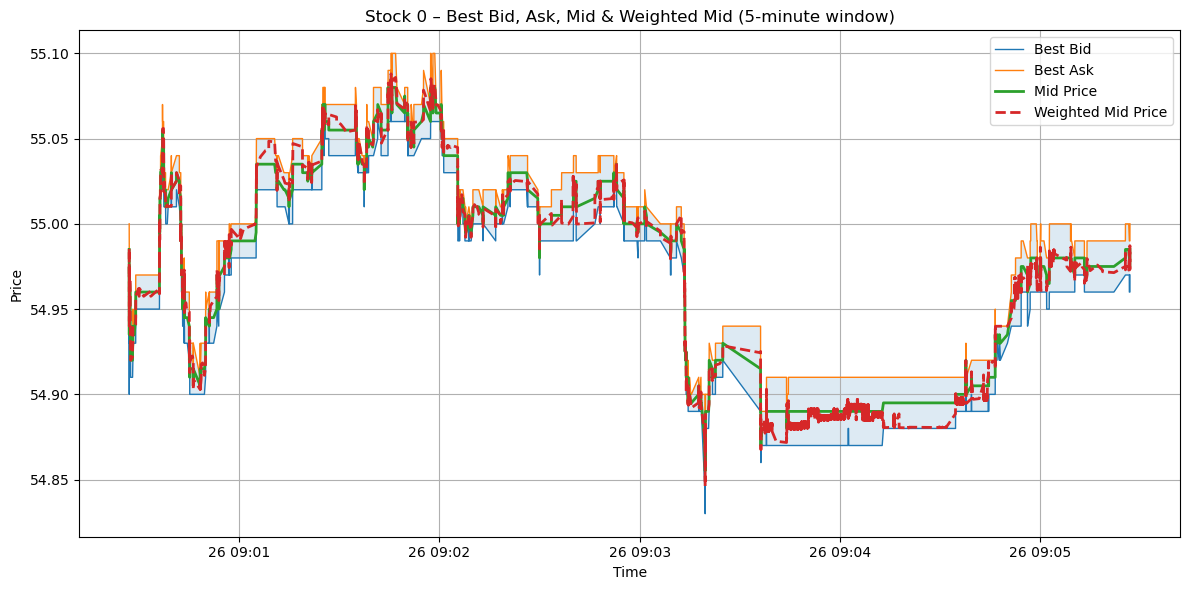

In [ ]:
plot_lob_prices_5min(
    df0_roll,
    title="Stock 0 – Best Bid, Ask, Mid & Weighted Mid (5-minute window)"
)

## 2.3 Spread

In [ ]:
def plot_spread_distribution_event_time(df, title):
    spread = df["spread"].dropna()

    plt.figure(figsize=(8, 5))
    plt.hist(spread, bins=50, density=True, alpha=0.7)
    plt.xlabel("Spread")
    plt.ylabel("Density")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return spread.describe()

In [ ]:
def spread_calendar_time(df, freq="1s"):
    return (
        df["spread"]
        .resample(freq)
        .last()
        .dropna()
    )

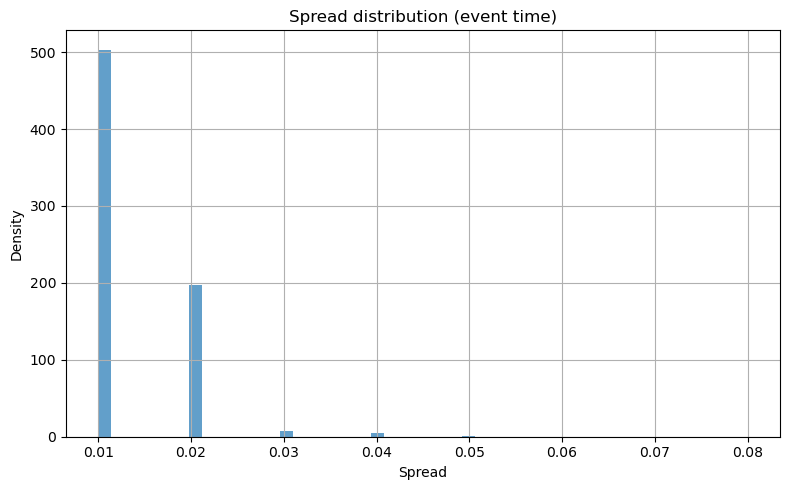

count    216539.000000
mean          0.013223
std           0.005389
min           0.010000
25%           0.010000
50%           0.010000
75%           0.020000
max           0.080000
Name: spread, dtype: float64


In [ ]:
df0_prices = df0_prices.copy()
df0_prices["spread"] = df0_prices["ap"] - df0_prices["bp"]
stats_event = plot_spread_distribution_event_time(
    df0_prices,
    "Spread distribution (event time)"
)
print(stats_event)

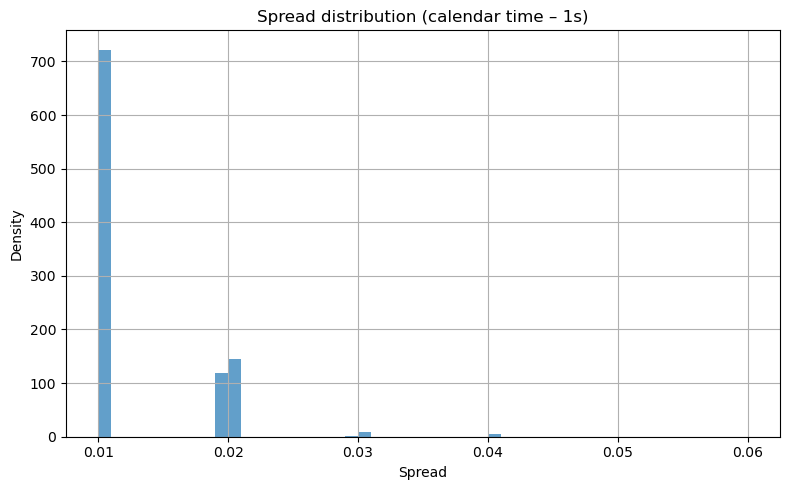

In [ ]:
spread_ct = spread_calendar_time(df0_prices, freq="1s")

plt.figure(figsize=(8, 5))
plt.hist(spread_ct, bins=50, density=True, alpha=0.7)
plt.xlabel("Spread")
plt.ylabel("Density")
plt.title("Spread distribution (calendar time – 1s)")
plt.grid(True)
plt.tight_layout()
plt.show()

Large spread small tick it's consistent with what we've seen before

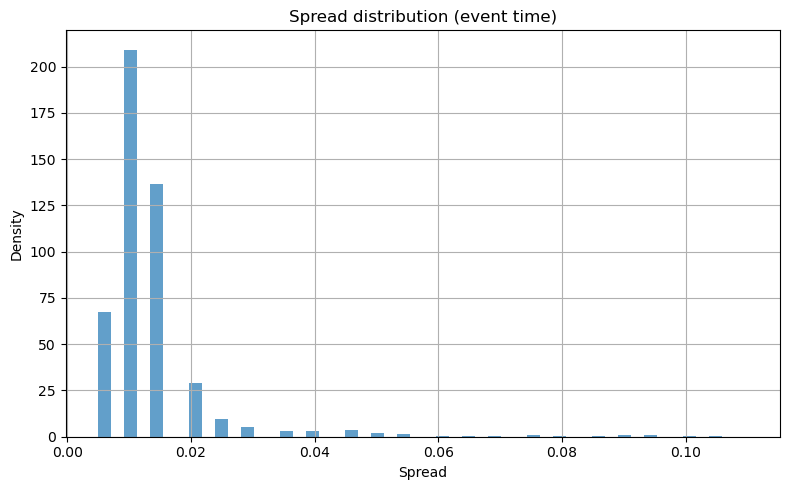

count    70425.000000
mean         0.013634
std          0.010346
min          0.005000
25%          0.010000
50%          0.010000
75%          0.015000
max          0.110000
Name: spread, dtype: float64


In [ ]:
df1_prices = add_price_metrics(df1[df1["type"]!="T"])
df1_prices = df1_prices.copy()
df1_prices["spread"] = df1_prices["ap"] - df1_prices["bp"]
stats_event = plot_spread_distribution_event_time(
    df1_prices,
    "Spread distribution (event time)"
)
print(stats_event)